Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. We have tested this notebook on a server with 4 NVidia V100 GPU (32GB) and 400GB CPU Ram.

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `nlp,ray,notebook` and `blendsearch` option:
```bash
pip install flaml[nlp,ray,notebook,blendsearch];
```

In [1]:
%pip install flaml[nlp,ray,notebook,blendsearch]

Let's run some examples. 

Note: throughout this notebook, you may see a few ModuleNotFoundErrors. As long as the cell successfully executes, you can ignore that error.

## 2. Sentiment Classification Example
### Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "mrpc", split="train").to_pandas()
dev_dataset = load_dataset("glue", "mrpc", split="validation").to_pandas()
test_dataset = load_dataset("glue", "mrpc", split="test").to_pandas()

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Take a look at the first 5 examples of this dataset:

In [3]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [2]:
custom_sent_keys = ["sentence1", "sentence2"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [ ]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
if not ray.is_initialized():
    ray.init() 

In [1]:
TIME_BUDGET=1200
automl_settings = {
    "time_budget": TIME_BUDGET,                  # setting the time budget
    "task": "seq-classification",       # setting the task as seq-classification
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   # setting the output directory
            "ckpt_per_epoch": 1,            # setting the number of checkoints per epoch
            "model_path": "bert-base-uncased",  # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4,
    "keep_search_state": True,          # keeping the search state
}

In [6]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=59250) {'loss': 0.3327, 'learning_rate': 1.0295123460382672e-05, 'epoch': 2.18}
(train pid=59407) {'loss': 0.4744, 'learning_rate': 3.8483947490148965e-06, 'epoch': 1.64}
(train pid=58929) {'loss': 0.1645, 'learning_rate': 4.8933330345560835e-06, 'epoch': 3.27}
(train pid=59592) {'loss': 0.5619, 'learning_rate': 1.3544721826857925e-05, 'epoch': 0.55}
(train pid=59407) {'eval_loss': 0.5415804386138916, 'eval_automl_metric': 0.13480392156862742, 'eval_runtime': 3.8874, 'eval_samples_per_second': 104.956, 'eval_steps_per_second': 104.956, 'epoch': 2.0}
(train pid=59407) {'train_runtime': 133.4439, 'train_samples_per_second': 54.974, 'train_steps_per_second': 13.744, 'train_loss': 0.4956582546754128, 'epoch': 2.0}
(train pid=59250) {'loss': 0.2012, 'learning_rate': 7.209055276814724e-06, 'epoch': 2.73}


(train pid=59407) ***** Running Prediction *****
(train pid=59407)   Num examples = 408
(train pid=59407)   Batch size = 1
(train pid=59407) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_5c51b244_32_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-26-12/checkpoint-1834/added_tokens.json. We won't load it.
(train pid=59407) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_5c51b244_32_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-26-12/checkpoint-1834/vocab.txt
(train pid=59407) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_5c51b244_32_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13

(train pid=59592) {'eval_loss': 0.5180040001869202, 'eval_automl_metric': 0.15931372549019607, 'eval_runtime': 3.7749, 'eval_samples_per_second': 108.082, 'eval_steps_per_second': 108.082, 'epoch': 1.0}
(train pid=58929) {'loss': 0.0951, 'learning_rate': 1.2306586074931466e-06, 'epoch': 3.82}
(train pid=59592) {'loss': 0.4703, 'learning_rate': 8.46798950794566e-06, 'epoch': 1.09}
(train pid=59250) {'eval_loss': 0.6077207326889038, 'eval_automl_metric': 0.11764705882352944, 'eval_runtime': 3.8401, 'eval_samples_per_second': 106.247, 'eval_steps_per_second': 106.247, 'epoch': 3.0}
(train pid=58929) {'eval_loss': 0.806081235408783, 'eval_automl_metric': 0.13480392156862742, 'eval_runtime': 3.7716, 'eval_samples_per_second': 108.177, 'eval_steps_per_second': 108.177, 'epoch': 4.0}
(train pid=58929) {'train_runtime': 256.0423, 'train_samples_per_second': 57.303, 'train_steps_per_second': 14.326, 'train_loss': 0.35705690737509027, 'epoch': 4.0}


(train pid=58929) ***** Running Prediction *****
(train pid=58929)   Num examples = 408
(train pid=58929)   Batch size = 1
(train pid=58929) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_227f7ab0_29_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13-24-35/checkpoint-3668/added_tokens.json. We won't load it.
(train pid=58929) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_227f7ab0_29_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13-24-35/checkpoint-3668/vocab.txt
(train pid=58929) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_227f7ab0_29_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13

(train pid=59250) {'loss': 0.1476, 'learning_rate': 4.122987093246777e-06, 'epoch': 3.27}
(train pid=59592) {'loss': 0.3574, 'learning_rate': 3.391257189033394e-06, 'epoch': 1.64}
(train pid=59592) {'eval_loss': 0.5781316757202148, 'eval_automl_metric': 0.1421568627450981, 'eval_runtime': 3.7277, 'eval_samples_per_second': 109.45, 'eval_steps_per_second': 109.45, 'epoch': 2.0}
(train pid=59592) {'train_runtime': 128.6158, 'train_samples_per_second': 57.038, 'train_steps_per_second': 14.26, 'train_loss': 0.4407762508745932, 'epoch': 2.0}


(train pid=59592) ***** Running Prediction *****
(train pid=59592)   Num examples = 408
(train pid=59592)   Batch size = 1


(train pid=59250) {'loss': 0.1029, 'learning_rate': 1.03691890967883e-06, 'epoch': 3.82}


(train pid=59592) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_89b0b9a7_33_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-27-29/checkpoint-1834/added_tokens.json. We won't load it.
(train pid=59592) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_89b0b9a7_33_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-27-29/checkpoint-1834/vocab.txt
(train pid=59592) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_89b0b9a7_33_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=2,per_device_trai_2022-07-21_13-27-29/checkpoint-1834/tokenizer.json
(train pid=59592) loading file None
(train pid=59592) loading file /data/xliu127/proj

(train pid=59250) {'eval_loss': 0.7132703065872192, 'eval_automl_metric': 0.12254901960784315, 'eval_runtime': 3.735, 'eval_samples_per_second': 109.237, 'eval_steps_per_second': 109.237, 'epoch': 4.0}
(train pid=59250) {'train_runtime': 264.9924, 'train_samples_per_second': 55.368, 'train_steps_per_second': 13.842, 'train_loss': 0.31339427247042223, 'epoch': 4.0}


(train pid=59250) ***** Running Prediction *****
(train pid=59250)   Num examples = 408
(train pid=59250)   Batch size = 1
(train pid=59250) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_45d8f8ce_31_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13-25-34/checkpoint-2751/added_tokens.json. We won't load it.
(train pid=59250) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_45d8f8ce_31_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13-25-34/checkpoint-2751/vocab.txt
(train pid=59250) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_13-07-38/train_45d8f8ce_31_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_13

{'loss': 0.405, 'learning_rate': 6.02286555920107e-06, 'epoch': 2.17}


[flaml.automl: 07-21 13:32:01] {3457} INFO - retrain transformer for 101.3s
[flaml.automl: 07-21 13:32:01] {3464} INFO - retrained model: None
[flaml.automl: 07-21 13:32:01] {2742} INFO - fit succeeded
[flaml.automl: 07-21 13:32:01] {2743} INFO - Time taken to find the best model: 1019.1050026416779
[flaml.automl: 07-21 13:32:01] {2754} WARNING - Time taken to find the best model is 85% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


{'train_runtime': 93.2817, 'train_samples_per_second': 117.965, 'train_steps_per_second': 7.397, 'train_loss': 0.3405460468236951, 'epoch': 3.0}


In [7]:
print("The best loss by FLAML: {}".format(automl.best_loss))

The best loss by FLAML: 0.12009803921568629


### Best model and metric

In [6]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'learning_rate': 1.4736175808553141e-05, 'num_train_epochs': 7.623375372739029, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.21605876280261357, 'weight_decay': 0.11938244526496489, 'adam_epsilon': 7.353322403647365e-07, 'seed': 42, 'global_max_steps': 1878, 'learner': 'transformer'}
Best accuracy on validation data: 0.9404
Training duration of best run: 157.7 s


In [8]:
import pickle
automl.pickle("automl.pkl")

with open("automl.pkl", "rb") as f:
    automl = pickle.load(f)

/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.528, 'learning_rate': 8.898933352349567e-06, 'epoch': 1.0}
{'eval_loss': 0.2549280524253845, 'eval_automl_metric': 0.08600917431192656, 'eval_runtime': 1.0003, 'eval_samples_per_second': 871.751, 'eval_steps_per_second': 54.984, 'epoch': 1.0}
{'loss': 0.2278, 'learning_rate': 1.3880017803076292e-05, 'epoch': 2.0}
{'eval_loss': 0.24966619908809662, 'eval_automl_metric': 0.06766055045871555, 'eval_runtime': 1.0201, 'eval_samples_per_second': 854.778, 'eval_steps_per_second': 53.914, 'epoch': 2.0}
{'loss': 0.1455, 'learning_rate': 1.1410179501562432e-05, 'epoch': 3.0}
{'eval_loss': 0.23046882450580597, 'eval_automl_metric': 0.059633027522935755, 'eval_runtime': 1.0097, 'eval_samples_per_second': 863.6, 'eval_steps_per_second': 54.47, 'epoch': 3.0}
{'eval_loss': 0.23046882450580597, 'eval_automl_metric': 0.059633027522935755, 'eval_runtime': 0.9726, 'eval_samples_per_second': 896.568, 'eval_steps_per_second': 56.55, 'epoch': 3.0}
{'train_runtime': 146.7879, 'train_samples_per_se

Using amp half precision backend
***** Running Prediction *****
  Num examples = 872
  Batch size = 64


In [9]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test, **{"per_device_eval_batch_size": 1})
print('Predicted labels', y_pred)

Using amp half precision backend
***** Running Prediction *****
  Num examples = 1821
  Batch size = 4


Predicted labels [0 0 1 ... 1 1 1]


### Comparing with Transformers

In Transformers, we can tune the hyperparameters using Trainer.hyperparameter_search. The code for tuning sequence classification looks like below:

In [5]:
from datasets import load_dataset, load_metric
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
dataset = load_dataset('glue', 'mrpc')
metric = load_metric('glue', 'mrpc')

def encode(examples):
    outputs = tokenizer(
        examples['sentence1'], examples['sentence2'], truncation=True)
    return outputs

encoded_dataset = dataset.map(encode, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        'bert-base-uncased', return_dict=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Evaluate during training and a bit more often
# than the default to be able to prune bad trials early.
# Disabling tqdm is a matter of preference.
training_args = TrainingArguments(
    "test", evaluation_strategy="steps", eval_steps=500, disable_tqdm=True)
trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    model_init=model_init,
    compute_metrics=compute_metrics,
)

import transformers
transformers.logging.set_verbosity_error()

# Default objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
trainer.hyperparameter_search(
    local_dir="data/output/",
    time_budget_s=TIME_BUDGET,
    direction="maximize", 
    backend="ray", 
    n_trials=-1, # number of trials,
    keep_checkpoints_num=1
)

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/xliu127/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-un

== Status ==
Current time: 2022-07-21 18:12:54 (running for 00:00:00.76)
Memory usage on this node: 13.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/96 CPUs, 1.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 105/infinite (104 PENDING, 1 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_69dd6_00000 | RUNNING  | 155.246.89.124:14389 |     5.61152e-06 |                  5 |                            64 |  8.15396

(_objective pid=14389) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=14389) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14389) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14389) Som

== Status ==
Current time: 2022-07-21 18:13:02 (running for 00:00:08.04)
Memory usage on this node: 19.0/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 109/infinite (105 PENDING, 4 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_69dd6_00000 | RUNNING  | 155.246.89.124:14389 |     5.61152e-06 |                  5 |                            64 |  8.15396

(_objective pid=14428) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
(_objective pid=14428) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14428) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14428) Som

== Status ==
Current time: 2022-07-21 18:13:07 (running for 00:00:13.06)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 109/infinite (105 PENDING, 4 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_69dd6_00000 | RUNNING  | 155.246.89.124:14389 |     5.61152e-06 |                  5 |                            64 |  8.15396

== Status ==
Current time: 2022-07-21 18:13:22 (running for 00:00:28.10)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 109/infinite (105 PENDING, 4 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_69dd6_00000 | RUNNING  | 155.246.89.124:14389 |     5.61152e-06 |                  5 |                            64 |  8.15396

== Status ==
Current time: 2022-07-21 18:13:37 (running for 00:00:43.15)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 109/infinite (105 PENDING, 4 RUNNING)
+------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+----------------------+-----------------+--------------------+-------------------------------+----------|
| _objective_69dd6_00000 | RUNNING  | 155.246.89.124:14389 |     5.61152e-06 |                  5 |                            64 |  8.15396

Result for _objective_69dd6_00001:
  date: 2022-07-21_18-13-42
  done: true
  epoch: 2.0
  eval_accuracy: 0.8063725490196079
  eval_f1: 0.870279146141215
  eval_loss: 0.4491980969905853
  eval_runtime: 0.7052
  eval_samples_per_second: 578.598
  eval_steps_per_second: 72.325
  experiment_id: 7c2a760e3cc4425a8f2c3b771f2436a3
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6766516951608228
  pid: 14428
  should_checkpoint: true
  time_since_restore: 42.43034482002258
  time_this_iter_s: 42.43034482002258
  time_total_s: 42.43034482002258
  timestamp: 1658452422
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00001
  warmup_time: 0.005004405975341797
  
Result for _objective_69dd6_00003:
  date: 2022-07-21_18-13-43
  done: true
  epoch: 2.0
  eval_accuracy: 0.6813725490196079
  eval_f1: 0.8104956268221574
  eval_loss: 0.635231614112854
  eval_runtime: 0.7118
  eval_samples_per_second: 573.166
  eval_steps_per_second: 71.646
 

(_objective pid=14570) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
(_objective pid=14570) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14570) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14570) Som

== Status ==
Current time: 2022-07-21 18:13:49 (running for 00:00:54.95)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 111/infinite (105 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00000 | RUNNING    | 155.246.89.124:14389 |     5.61152e-06

(_objective pid=14570) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=14570)   warnings.warn(
(_objective pid=14603) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=14603)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:13:54 (running for 00:00:59.96)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 111/infinite (105 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00000 | RUNNING    | 155.246.89.124:14389 |     5.61152e-06

== Status ==
Current time: 2022-07-21 18:14:04 (running for 00:01:10.13)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 111/infinite (105 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00000 | RUNNING    | 155.246.89.124:14389 |     5.61152e-06

== Status ==
Current time: 2022-07-21 18:14:14 (running for 00:01:20.17)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 111/infinite (105 PENDING, 4 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00000 | RUNNING    | 155.246.89.124:14389 |     5.61152e-06

Result for _objective_69dd6_00000:
  date: 2022-07-21_18-14-19
  done: false
  epoch: 4.35
  eval_accuracy: 0.7916666666666666
  eval_f1: 0.8580968280467446
  eval_loss: 0.5054973363876343
  eval_runtime: 0.706
  eval_samples_per_second: 577.906
  eval_steps_per_second: 72.238
  experiment_id: b5f186f010ee444d8bca295599fb50a6
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6497634947134112
  pid: 14389
  should_checkpoint: true
  time_since_restore: 82.90014028549194
  time_this_iter_s: 82.90014028549194
  time_total_s: 82.90014028549194
  timestamp: 1658452459
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00000
  warmup_time: 0.003940582275390625
  
(_objective pid=14429) {'loss': 0.4409, 'learning_rate': 1.0811630695937156e-06, 'epoch': 4.35}
(_objective pid=14429) {'eval_loss': 0.4387318193912506, 'eval_accuracy': 0.821078431372549, 'eval_f1': 0.8764805414551609, 'eval_runtime': 0.7001, 'eval_samples_per_second': 582.

(_objective pid=14670) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=14670) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14670) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14670) Som

== Status ==
Current time: 2022-07-21 18:14:42 (running for 00:01:47.98)
Memory usage on this node: 22.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 113/infinite (105 PENDING, 4 RUNNING, 4 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00004 | RUNNING    | 155.246.89.124:14570 |     2.3102e-06 

(_objective pid=14706) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
(_objective pid=14706) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14706) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14706) Som

== Status ==
Current time: 2022-07-21 18:14:47 (running for 00:01:53.00)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 113/infinite (105 PENDING, 4 RUNNING, 4 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00004 | RUNNING    | 155.246.89.124:14570 |     2.3102e-06 

== Status ==
Current time: 2022-07-21 18:14:57 (running for 00:02:03.03)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 113/infinite (105 PENDING, 4 RUNNING, 4 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00004 | RUNNING    | 155.246.89.124:14570 |     2.3102e-06 

(_objective pid=14603) {'eval_loss': 0.5211783647537231, 'eval_accuracy': 0.803921568627451, 'eval_f1': 0.8648648648648648, 'eval_runtime': 0.71, 'eval_samples_per_second': 574.667, 'eval_steps_per_second': 71.833, 'epoch': 4.0}
Result for _objective_69dd6_00005:
  date: 2022-07-21_18-15-04
  done: true
  epoch: 4.0
  eval_accuracy: 0.803921568627451
  eval_f1: 0.8648648648648648
  eval_loss: 0.5211783647537231
  eval_runtime: 0.71
  eval_samples_per_second: 574.667
  eval_steps_per_second: 71.833
  experiment_id: 9bf7cc27d84c4184ae0c7a832ea15043
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6687864334923157
  pid: 14603
  should_checkpoint: true
  time_since_restore: 78.435870885849
  time_this_iter_s: 78.435870885849
  time_total_s: 78.435870885849
  timestamp: 1658452504
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00005
  warmup_time: 0.0043048858642578125
  
(_objective pid=14570) {'loss': 0.5994, 'learning_rate'

(_objective pid=14759) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=14759) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14759) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14759) Som

== Status ==
Current time: 2022-07-21 18:15:13 (running for 00:02:19.56)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 114/infinite (105 PENDING, 4 RUNNING, 5 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00004 | RUNNING    | 155.246.89.124:14570 |     2.3102e-06 

Result for _objective_69dd6_00006:
  date: 2022-07-21_18-15-19
  done: true
  epoch: 2.0
  eval_accuracy: 0.8137254901960784
  eval_f1: 0.8733333333333333
  eval_loss: 0.45492023229599
  eval_runtime: 0.7071
  eval_samples_per_second: 576.976
  eval_steps_per_second: 72.122
  experiment_id: 2be5577acaae432a852888e13f061c21
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6870588235294117
  pid: 14670
  should_checkpoint: true
  time_since_restore: 43.766663789749146
  time_this_iter_s: 43.766663789749146
  time_total_s: 43.766663789749146
  timestamp: 1658452519
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00006
  warmup_time: 0.004464387893676758
  
Result for _objective_69dd6_00004:
  date: 2022-07-21_18-15-08
  done: true
  epoch: 4.35
  eval_accuracy: 0.7009803921568627
  eval_f1: 0.8189910979228486
  eval_loss: 0.5411626696586609
  eval_runtime: 0.7095
  eval_samples_per_second: 575.02
  eval_steps_per_second: 71.87

(_objective pid=14807) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=14807) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14807) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14807) Som

== Status ==
Current time: 2022-07-21 18:15:27 (running for 00:02:33.02)
Memory usage on this node: 23.4/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 116/infinite (105 PENDING, 4 RUNNING, 7 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00007 | RUNNING    | 155.246.89.124:14706 |     5.4041e-06 

(_objective pid=14843) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=14843)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:15:32 (running for 00:02:38.05)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 116/infinite (105 PENDING, 4 RUNNING, 7 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00007 | RUNNING    | 155.246.89.124:14706 |     5.4041e-06 

(_objective pid=14706) {'train_runtime': 52.4613, 'train_samples_per_second': 209.754, 'train_steps_per_second': 6.576, 'train_loss': 0.5804045746291893, 'epoch': 3.0}
(_objective pid=14706) {'eval_loss': 0.5164138078689575, 'eval_accuracy': 0.7426470588235294, 'eval_f1': 0.8314606741573034, 'eval_runtime': 0.7032, 'eval_samples_per_second': 580.207, 'eval_steps_per_second': 72.526, 'epoch': 3.0}
Result for _objective_69dd6_00007:
  date: 2022-07-21_18-15-40
  done: true
  epoch: 3.0
  eval_accuracy: 0.7426470588235294
  eval_f1: 0.8314606741573034
  eval_loss: 0.5164138078689575
  eval_runtime: 0.7032
  eval_samples_per_second: 580.207
  eval_steps_per_second: 72.526
  experiment_id: fb00756b2f6f45b4927760f7e64e2ace
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5741077329808328
  pid: 14706
  should_checkpoint: true
  time_since_restore: 60.308714151382446
  time_this_iter_s: 60.308714151382446
  time_total_s: 60.308714151382446
  timestamp: 

(_objective pid=14985) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
(_objective pid=14985) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14985) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14985) Som

== Status ==
Current time: 2022-07-21 18:15:51 (running for 00:02:57.05)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 117/infinite (105 PENDING, 4 RUNNING, 8 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00008 | RUNNING    | 155.246.89.124:14759 |     1.53049e-05

== Status ==
Current time: 2022-07-21 18:16:01 (running for 00:03:07.08)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 117/infinite (105 PENDING, 4 RUNNING, 8 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00008 | RUNNING    | 155.246.89.124:14759 |     1.53049e-05

Result for _objective_69dd6_00008:
  date: 2022-07-21_18-16-08
  done: true
  epoch: 3.0
  eval_accuracy: 0.8088235294117647
  eval_f1: 0.8725490196078431
  eval_loss: 0.5124346017837524
  eval_runtime: 0.7162
  eval_samples_per_second: 569.645
  eval_steps_per_second: 71.206
  experiment_id: 707cc9706374434bbdd820ce07e91a2a
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6813725490196079
  pid: 14759
  should_checkpoint: true
  time_since_restore: 61.669899463653564
  time_this_iter_s: 61.669899463653564
  time_total_s: 61.669899463653564
  timestamp: 1658452568
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00008
  warmup_time: 0.0043506622314453125
  


(_objective pid=15035) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=15035) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15035) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15035) Som

== Status ==
Current time: 2022-07-21 18:16:14 (running for 00:03:20.07)
Memory usage on this node: 22.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00011 | RUNNING    | 155.246.89.124:14985 |     2.89593e-0

(_objective pid=15074) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15074)   warnings.warn(
(_objective pid=15080) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15080)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:16:19 (running for 00:03:25.10)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00011 | RUNNING    | 155.246.89.124:14985 |     2.89593e-0

== Status ==
Current time: 2022-07-21 18:16:29 (running for 00:03:35.14)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00011 | RUNNING    | 155.246.89.124:14985 |     2.89593e-0

== Status ==
Current time: 2022-07-21 18:16:39 (running for 00:03:45.17)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00011 | RUNNING    | 155.246.89.124:14985 |     2.89593e-0

== Status ==
Current time: 2022-07-21 18:16:49 (running for 00:03:55.20)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00011 | RUNNING    | 155.246.89.124:14985 |     2.89593e-0

(_objective pid=14985) {'train_runtime': 69.3328, 'train_samples_per_second': 211.617, 'train_steps_per_second': 6.635, 'train_loss': 0.5860705831776495, 'epoch': 4.0}
== Status ==
Current time: 2022-07-21 18:16:59 (running for 00:04:05.24)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 120/infinite (105 PENDING, 4 RUNNING, 11 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+------

(_objective pid=15176) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
(_objective pid=15176) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15176) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15176) Som

Result for _objective_69dd6_00012:
  date: 2022-07-21_18-17-07
  done: true
  epoch: 3.0
  eval_accuracy: 0.7990196078431373
  eval_f1: 0.8637873754152825
  eval_loss: 0.4926145076751709
  eval_runtime: 0.6973
  eval_samples_per_second: 585.094
  eval_steps_per_second: 73.137
  experiment_id: 28e79585a83345298e413c5eb31cecb2
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6628069832584198
  pid: 15035
  should_checkpoint: true
  time_since_restore: 59.550392389297485
  time_this_iter_s: 59.550392389297485
  time_total_s: 59.550392389297485
  timestamp: 1658452627
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00012
  warmup_time: 0.004527091979980469
  


(_objective pid=15176) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15176)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:17:12 (running for 00:04:18.13)
Memory usage on this node: 23.0/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 122/infinite (105 PENDING, 4 RUNNING, 13 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00013 | RUNNING    | 155.246.89.124:15074 |     2.31458e-0

(_objective pid=15216) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=15216) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15216) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15216) Som

== Status ==
Current time: 2022-07-21 18:17:17 (running for 00:04:23.14)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 122/infinite (105 PENDING, 4 RUNNING, 13 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00013 | RUNNING    | 155.246.89.124:15074 |     2.31458e-0

(_objective pid=15074) {'train_runtime': 70.2571, 'train_samples_per_second': 208.833, 'train_steps_per_second': 6.547, 'train_loss': 0.5810901144276495, 'epoch': 4.0}
(_objective pid=15074) {'eval_loss': 0.5369256138801575, 'eval_accuracy': 0.7058823529411765, 'eval_f1': 0.8192771084337349, 'eval_runtime': 0.727, 'eval_samples_per_second': 561.234, 'eval_steps_per_second': 70.154, 'epoch': 4.0}
== Status ==
Current time: 2022-07-21 18:17:27 (running for 00:04:33.18)
Memory usage on this node: 25.0/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 122/infinite (105 PENDING, 4 RUNNING, 13 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-----------

(_objective pid=15266) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=15266) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15266) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15266) Som

(_objective pid=15080) {'loss': 0.3657, 'learning_rate': 1.781533832658595e-06, 'epoch': 4.35}
(_objective pid=15080) {'eval_loss': 0.43705764412879944, 'eval_accuracy': 0.8455882352941176, 'eval_f1': 0.8919382504288165, 'eval_runtime': 0.7191, 'eval_samples_per_second': 567.395, 'eval_steps_per_second': 70.924, 'epoch': 4.35}


(_objective pid=15266) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15266)   warnings.warn(


Result for _objective_69dd6_00014:
  date: 2022-07-21_18-17-37
  done: false
  epoch: 4.35
  eval_accuracy: 0.8455882352941176
  eval_f1: 0.8919382504288165
  eval_loss: 0.43705764412879944
  eval_runtime: 0.7191
  eval_samples_per_second: 567.395
  eval_steps_per_second: 70.924
  experiment_id: 326f459d8f1c4c28af3263a1d97cf6d1
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7375264857229342
  pid: 15080
  should_checkpoint: true
  time_since_restore: 85.86882424354553
  time_this_iter_s: 85.86882424354553
  time_total_s: 85.86882424354553
  timestamp: 1658452657
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00014
  warmup_time: 0.004141330718994141
  
== Status ==
Current time: 2022-07-21 18:17:42 (running for 00:04:47.93)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Res

(_objective pid=15080) {'train_runtime': 94.7001, 'train_samples_per_second': 193.664, 'train_steps_per_second': 6.072, 'train_loss': 0.33733815732209577, 'epoch': 5.0}
Result for _objective_69dd6_00014:
  date: 2022-07-21_18-17-37
  done: true
  epoch: 4.35
  eval_accuracy: 0.8455882352941176
  eval_f1: 0.8919382504288165
  eval_loss: 0.43705764412879944
  eval_runtime: 0.7191
  eval_samples_per_second: 567.395
  eval_steps_per_second: 70.924
  experiment_id: 326f459d8f1c4c28af3263a1d97cf6d1
  experiment_tag: 14_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=8,seed=38.8138
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7375264857229342
  pid: 15080
  should_checkpoint: true
  time_since_restore: 85.86882424354553
  time_this_iter_s: 85.86882424354553
  time_total_s: 85.86882424354553
  timestamp: 1658452657
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00014
  warmup_time: 0.004141330718994141
  


(_objective pid=15316) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=15316) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15316) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15316) Som

== Status ==
Current time: 2022-07-21 18:17:56 (running for 00:05:02.15)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 125/infinite (105 PENDING, 4 RUNNING, 16 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00016 | RUNNING    | 155.246.89.124:15216 |     1.23156e-0

(_objective pid=15351) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=15351) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15351) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15351) Som

== Status ==
Current time: 2022-07-21 18:18:01 (running for 00:05:07.31)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 125/infinite (105 PENDING, 4 RUNNING, 16 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00016 | RUNNING    | 155.246.89.124:15216 |     1.23156e-0

(_objective pid=15266) {'train_runtime': 35.4891, 'train_samples_per_second': 206.712, 'train_steps_per_second': 6.481, 'train_loss': 0.5437726228133491, 'epoch': 2.0}
== Status ==
Current time: 2022-07-21 18:18:11 (running for 00:05:17.35)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 125/infinite (105 PENDING, 4 RUNNING, 16 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+------

(_objective pid=15404) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
(_objective pid=15404) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15404) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15404) Som

Result for _objective_69dd6_00019:
  date: 2022-07-21_18-18-19
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6544497013092041
  eval_runtime: 0.7152
  eval_samples_per_second: 570.444
  eval_steps_per_second: 71.306
  experiment_id: 2304a1e18f0444249440eb583d294ccc
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 15351
  should_checkpoint: true
  time_since_restore: 26.04690718650818
  time_this_iter_s: 26.04690718650818
  time_total_s: 26.04690718650818
  timestamp: 1658452699
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00019
  warmup_time: 0.004496097564697266
  
== Status ==
Current time: 2022-07-21 18:18:19 (running for 00:05:25.51)
Memory usage on this node: 21.6/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result

(_objective pid=15438) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=15438) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15438) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15438) Som

== Status ==
Current time: 2022-07-21 18:18:25 (running for 00:05:31.20)
Memory usage on this node: 23.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 128/infinite (105 PENDING, 4 RUNNING, 19 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00016 | RUNNING    | 155.246.89.124:15216 |     1.23156e-0

(_objective pid=15479) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15479)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:18:30 (running for 00:05:36.21)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 128/infinite (105 PENDING, 4 RUNNING, 19 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00016 | RUNNING    | 155.246.89.124:15216 |     1.23156e-0

== Status ==
Current time: 2022-07-21 18:18:44 (running for 00:05:49.90)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 128/infinite (105 PENDING, 4 RUNNING, 19 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00016 | RUNNING    | 155.246.89.124:15216 |     1.23156e-0

(_objective pid=15537) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=15537) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15537) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15537) Som

== Status ==
Current time: 2022-07-21 18:18:56 (running for 00:06:02.27)
Memory usage on this node: 24.9/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 130/infinite (105 PENDING, 4 RUNNING, 21 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00020 | RUNNING    | 155.246.89.124:15404 |     3.86346e-0

(_objective pid=15569) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15569)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:19:01 (running for 00:06:07.29)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 130/infinite (105 PENDING, 4 RUNNING, 21 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00020 | RUNNING    | 155.246.89.124:15404 |     3.86346e-0

== Status ==
Current time: 2022-07-21 18:19:11 (running for 00:06:17.33)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 130/infinite (105 PENDING, 4 RUNNING, 21 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00020 | RUNNING    | 155.246.89.124:15404 |     3.86346e-0

Result for _objective_69dd6_00020:
  date: 2022-07-21_18-19-16
  done: true
  epoch: 3.0
  eval_accuracy: 0.7205882352941176
  eval_f1: 0.8267477203647416
  eval_loss: 0.5297566056251526
  eval_runtime: 0.7061
  eval_samples_per_second: 577.796
  eval_steps_per_second: 72.224
  experiment_id: 5abfc5d75b3e40639052df03da5b6177
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5473359556588593
  pid: 15404
  should_checkpoint: true
  time_since_restore: 60.4823842048645
  time_this_iter_s: 60.4823842048645
  time_total_s: 60.4823842048645
  timestamp: 1658452756
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00020
  warmup_time: 0.004002571105957031
  
Result for _objective_69dd6_00021:
  date: 2022-07-21_18-19-18
  done: true
  epoch: 3.0
  eval_accuracy: 0.8357843137254902
  eval_f1: 0.8870151770657673
  eval_loss: 0.46171578764915466
  eval_runtime: 0.7047
  eval_samples_per_second: 579.009
  eval_steps_per_second: 72.376
 

(_objective pid=15637) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=15637) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15637) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15637) Som

== Status ==
Current time: 2022-07-21 18:19:23 (running for 00:06:29.25)
Memory usage on this node: 22.1/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 132/infinite (105 PENDING, 4 RUNNING, 23 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00023 | RUNNING    | 155.246.89.124:15537 |     1.55174e-0

(_objective pid=15669) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=15669) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15669) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15669) Som

== Status ==
Current time: 2022-07-21 18:19:28 (running for 00:06:34.27)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 132/infinite (105 PENDING, 4 RUNNING, 23 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00023 | RUNNING    | 155.246.89.124:15537 |     1.55174e-0

== Status ==
Current time: 2022-07-21 18:19:38 (running for 00:06:44.31)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 132/infinite (105 PENDING, 4 RUNNING, 23 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00023 | RUNNING    | 155.246.89.124:15537 |     1.55174e-0

== Status ==
Current time: 2022-07-21 18:19:48 (running for 00:06:54.35)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 132/infinite (105 PENDING, 4 RUNNING, 23 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00023 | RUNNING    | 155.246.89.124:15537 |     1.55174e-0

(_objective pid=15727) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=15727) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15727) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15727) Som

(_objective pid=15637) {'train_runtime': 35.4157, 'train_samples_per_second': 207.14, 'train_steps_per_second': 6.494, 'train_loss': 0.418805163839589, 'epoch': 2.0}


(_objective pid=15727) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15727)   warnings.warn(


(_objective pid=15669) {'train_runtime': 34.8831, 'train_samples_per_second': 210.302, 'train_steps_per_second': 6.593, 'train_loss': 0.5509584509808084, 'epoch': 2.0}
(_objective pid=15637) {'eval_loss': 0.345292329788208, 'eval_accuracy': 0.8529411764705882, 'eval_f1': 0.8961937716262977, 'eval_runtime': 0.707, 'eval_samples_per_second': 577.067, 'eval_steps_per_second': 72.133, 'epoch': 2.0}
(_objective pid=15669) {'eval_loss': 0.5177404880523682, 'eval_accuracy': 0.7598039215686274, 'eval_f1': 0.8382838283828382, 'eval_runtime': 0.6999, 'eval_samples_per_second': 582.979, 'eval_steps_per_second': 72.872, 'epoch': 2.0}
Result for _objective_69dd6_00025:
  date: 2022-07-21_18-20-03
  done: true
  epoch: 2.0
  eval_accuracy: 0.8529411764705882
  eval_f1: 0.8961937716262977
  eval_loss: 0.345292329788208
  eval_runtime: 0.707
  eval_samples_per_second: 577.067
  eval_steps_per_second: 72.133
  experiment_id: de74edc5df17434da7417cf9ac1a9e88
  hostname: tmdev
  iterations_since_restore:

(_objective pid=15776) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
(_objective pid=15776) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15776) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15776) Som

== Status ==
Current time: 2022-07-21 18:20:09 (running for 00:07:15.30)
Memory usage on this node: 22.1/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 135/infinite (105 PENDING, 4 RUNNING, 26 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00023 | RUNNING    | 155.246.89.124:15537 |     1.55174e-0

(_objective pid=15776) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15776)   warnings.warn(
(_objective pid=15774) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=15774)   warnings.warn(


Result for _objective_69dd6_00023:
  date: 2022-07-21_18-20-12
  done: false
  epoch: 4.35
  eval_accuracy: 0.7034313725490197
  eval_f1: 0.8207407407407408
  eval_loss: 0.5603407621383667
  eval_runtime: 0.7009
  eval_samples_per_second: 582.125
  eval_steps_per_second: 72.766
  experiment_id: dadacf57db2f4372b5645c5ccbc18123
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5241721132897603
  pid: 15537
  should_checkpoint: true
  time_since_restore: 82.8525927066803
  time_this_iter_s: 82.8525927066803
  time_total_s: 82.8525927066803
  timestamp: 1658452812
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00023
  warmup_time: 0.005011558532714844
  
== Status ==
Current time: 2022-07-21 18:20:17 (running for 00:07:23.77)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result 

(_objective pid=15860) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=15860) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15860) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15860) Som

== Status ==
Current time: 2022-07-21 18:20:31 (running for 00:07:37.29)
Memory usage on this node: 23.1/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00028 | RUNNING    | 155.246.89.124:15774 |     6.53331e-0

(_objective pid=15896) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=15896) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15896) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15896) Som

== Status ==
Current time: 2022-07-21 18:20:36 (running for 00:07:42.32)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00028 | RUNNING    | 155.246.89.124:15774 |     6.53331e-0

== Status ==
Current time: 2022-07-21 18:20:46 (running for 00:07:52.36)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00028 | RUNNING    | 155.246.89.124:15774 |     6.53331e-0

== Status ==
Current time: 2022-07-21 18:20:56 (running for 00:08:02.41)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 137/infinite (105 PENDING, 4 RUNNING, 28 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00028 | RUNNING    | 155.246.89.124:15774 |     6.53331e-0

(_objective pid=15776) {'train_runtime': 52.2356, 'train_samples_per_second': 210.661, 'train_steps_per_second': 6.605, 'train_loss': 0.5844035715296648, 'epoch': 3.0}
(_objective pid=15776) {'eval_loss': 0.5386871099472046, 'eval_accuracy': 0.7083333333333334, 'eval_f1': 0.8188736681887367, 'eval_runtime': 0.6972, 'eval_samples_per_second': 585.195, 'eval_steps_per_second': 73.149, 'epoch': 3.0}
Result for _objective_69dd6_00029:
  date: 2022-07-21_18-21-06
  done: true
  epoch: 3.0
  eval_accuracy: 0.7083333333333334
  eval_f1: 0.8188736681887367
  eval_loss: 0.5386871099472046
  eval_runtime: 0.6972
  eval_samples_per_second: 585.195
  eval_steps_per_second: 73.149
  experiment_id: df07c0ed860a4905b64a436acdbc2366
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5272070015220702
  pid: 15776
  should_checkpoint: true
  time_since_restore: 60.1130690574646
  time_this_iter_s: 60.1130690574646
  time_total_s: 60.1130690574646
  timestamp: 165845

(_objective pid=16047) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=16047) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16047) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16047) Som

== Status ==
Current time: 2022-07-21 18:21:14 (running for 00:08:20.67)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 138/infinite (105 PENDING, 4 RUNNING, 29 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00028 | RUNNING    | 155.246.89.124:15774 |     6.53331e-0

(_objective pid=16047) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16047)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:21:19 (running for 00:08:25.70)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 138/infinite (105 PENDING, 4 RUNNING, 29 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00028 | RUNNING    | 155.246.89.124:15774 |     6.53331e-0

(_objective pid=15774) {'loss': 0.2566, 'learning_rate': 8.521702461166613e-06, 'epoch': 4.35}
(_objective pid=15774) {'eval_loss': 0.6253156661987305, 'eval_accuracy': 0.8602941176470589, 'eval_f1': 0.9028960817717206, 'eval_runtime': 0.7097, 'eval_samples_per_second': 574.868, 'eval_steps_per_second': 71.858, 'epoch': 4.35}
== Status ==
Current time: 2022-07-21 18:21:29 (running for 00:08:35.74)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 138/infinite (105 PENDING, 4 RUNNING, 29 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   le

== Status ==
Current time: 2022-07-21 18:21:40 (running for 00:08:46.49)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 138/infinite (105 PENDING, 4 RUNNING, 29 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00028 | RUNNING    | 155.246.89.124:15774 |     6.53331e-0

(_objective pid=15860) {'loss': 0.2182, 'learning_rate': 9.436017189998359e-06, 'epoch': 4.35}
(_objective pid=15860) {'eval_loss': 0.7862746119499207, 'eval_accuracy': 0.8480392156862745, 'eval_f1': 0.8912280701754387, 'eval_runtime': 0.7171, 'eval_samples_per_second': 568.933, 'eval_steps_per_second': 71.117, 'epoch': 4.35}


(_objective pid=16103) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(_objective pid=16103) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16103) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16103) Som

Result for _objective_69dd6_00030:
  date: 2022-07-21_18-21-49
  done: false
  epoch: 4.35
  eval_accuracy: 0.8480392156862745
  eval_f1: 0.8912280701754387
  eval_loss: 0.7862746119499207
  eval_runtime: 0.7171
  eval_samples_per_second: 568.933
  eval_steps_per_second: 71.117
  experiment_id: 9eec325dcf854b3499381366f4d96ef0
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7392672858617133
  pid: 15860
  should_checkpoint: true
  time_since_restore: 85.02760720252991
  time_this_iter_s: 85.02760720252991
  time_total_s: 85.02760720252991
  timestamp: 1658452909
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00030
  warmup_time: 0.004164457321166992
  


(_objective pid=16103) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16103)   warnings.warn(
(_objective pid=16140) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
(_objective pid=16140) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

== Status ==
Current time: 2022-07-21 18:21:54 (running for 00:09:00.67)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 140/infinite (105 PENDING, 4 RUNNING, 31 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00030 | RUNNING    | 155.246.89.124:15860 |     7.23428e-0

(_objective pid=16140) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16140)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:21:59 (running for 00:09:05.69)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 140/infinite (105 PENDING, 4 RUNNING, 31 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00030 | RUNNING    | 155.246.89.124:15860 |     7.23428e-0

(_objective pid=16188) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=16188) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16188) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16188) Som

== Status ==
Current time: 2022-07-21 18:22:08 (running for 00:09:14.45)
Memory usage on this node: 23.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 141/infinite (105 PENDING, 4 RUNNING, 32 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00032 | RUNNING    | 155.246.89.124:16047 |     6.09703e-0

(_objective pid=16188) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16188)   warnings.warn(


Result for _objective_69dd6_00033:
  date: 2022-07-21_18-22-12
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.5931549668312073
  eval_runtime: 0.7227
  eval_samples_per_second: 564.542
  eval_steps_per_second: 70.568
  experiment_id: ce44801a522d4832a83df7a75a527951
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 16103
  should_checkpoint: true
  time_since_restore: 25.56890869140625
  time_this_iter_s: 25.56890869140625
  time_total_s: 25.56890869140625
  timestamp: 1658452932
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00033
  warmup_time: 0.005347251892089844
  


(_objective pid=16231) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=16231) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16231) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16231) Som

== Status ==
Current time: 2022-07-21 18:22:17 (running for 00:09:23.38)
Memory usage on this node: 22.6/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 143/infinite (105 PENDING, 4 RUNNING, 34 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00034 | RUNNING    | 155.246.89.124:16140 |     7.14851e-0

(_objective pid=16231) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16231)   warnings.warn(
(_objective pid=16264) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16264)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:22:22 (running for 00:09:28.41)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 143/infinite (105 PENDING, 4 RUNNING, 34 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00034 | RUNNING    | 155.246.89.124:16140 |     7.14851e-0

== Status ==
Current time: 2022-07-21 18:22:32 (running for 00:09:38.44)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 143/infinite (105 PENDING, 4 RUNNING, 34 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00034 | RUNNING    | 155.246.89.124:16140 |     7.14851e-0

(_objective pid=16264) {'train_runtime': 18.2392, 'train_samples_per_second': 201.105, 'train_steps_per_second': 6.305, 'train_loss': 0.6323141346807065, 'epoch': 1.0}
(_objective pid=16264) {'eval_loss': 0.5927693247795105, 'eval_accuracy': 0.6838235294117647, 'eval_f1': 0.8122270742358079, 'eval_runtime': 0.7077, 'eval_samples_per_second': 576.489, 'eval_steps_per_second': 72.061, 'epoch': 1.0}
Result for _objective_69dd6_00037:
  date: 2022-07-21_18-22-40
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.5927693247795105
  eval_runtime: 0.7077
  eval_samples_per_second: 576.489
  eval_steps_per_second: 72.061
  experiment_id: 81f054bb57d04b88be21bcf88d9cea5b
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 16264
  should_checkpoint: true
  time_since_restore: 26.40869164466858
  time_this_iter_s: 26.40869164466858
  time_total_s: 26.40869164466858
  timestamp: 165

(_objective pid=16320) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
(_objective pid=16320) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16320) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16320) Som

== Status ==
Current time: 2022-07-21 18:22:46 (running for 00:09:52.42)
Memory usage on this node: 23.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 144/infinite (105 PENDING, 4 RUNNING, 35 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00034 | RUNNING    | 155.246.89.124:16140 |     7.14851e-0

(_objective pid=16320) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16320)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:22:51 (running for 00:09:57.44)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 144/infinite (105 PENDING, 4 RUNNING, 35 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00034 | RUNNING    | 155.246.89.124:16140 |     7.14851e-0

Result for _objective_69dd6_00036:
  date: 2022-07-21_18-22-57
  done: true
  epoch: 2.0
  eval_accuracy: 0.8333333333333334
  eval_f1: 0.8847457627118644
  eval_loss: 0.37553152441978455
  eval_runtime: 0.698
  eval_samples_per_second: 584.497
  eval_steps_per_second: 73.062
  experiment_id: 30701e6be95a4cfd9e40ad6971c33f8d
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.718079096045198
  pid: 16231
  should_checkpoint: true
  time_since_restore: 43.42806363105774
  time_this_iter_s: 43.42806363105774
  time_total_s: 43.42806363105774
  timestamp: 1658452977
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00036
  warmup_time: 0.0038361549377441406
  
== Status ==
Current time: 2022-07-21 18:23:02 (running for 00:10:08.42)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result

(_objective pid=16365) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
(_objective pid=16365) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16365) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16365) Som

(_objective pid=16140) {'train_runtime': 69.3953, 'train_samples_per_second': 211.426, 'train_steps_per_second': 6.629, 'train_loss': 0.47288556306258495, 'epoch': 4.0}
(_objective pid=16188) {'train_runtime': 53.6975, 'train_samples_per_second': 204.926, 'train_steps_per_second': 6.425, 'train_loss': 0.6183022761690444, 'epoch': 3.0}
(_objective pid=16140) {'eval_loss': 0.4496769607067108, 'eval_accuracy': 0.8112745098039216, 'eval_f1': 0.8739770867430443, 'eval_runtime': 0.6961, 'eval_samples_per_second': 586.115, 'eval_steps_per_second': 73.264, 'epoch': 4.0}
(_objective pid=16188) {'eval_loss': 0.6032273769378662, 'eval_accuracy': 0.6838235294117647, 'eval_f1': 0.8122270742358079, 'eval_runtime': 0.7162, 'eval_samples_per_second': 569.656, 'eval_steps_per_second': 71.207, 'epoch': 3.0}


(_objective pid=16365) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16365)   warnings.warn(


Result for _objective_69dd6_00034:
  date: 2022-07-21_18-23-06
  done: true
  epoch: 4.0
  eval_accuracy: 0.8112745098039216
  eval_f1: 0.8739770867430443
  eval_loss: 0.4496769607067108
  eval_runtime: 0.6961
  eval_samples_per_second: 586.115
  eval_steps_per_second: 73.264
  experiment_id: 0b10f3246b5f4e99addd37fcbfc596d6
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6852515965469659
  pid: 16140
  should_checkpoint: true
  time_since_restore: 77.09054899215698
  time_this_iter_s: 77.09054899215698
  time_total_s: 77.09054899215698
  timestamp: 1658452986
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00034
  warmup_time: 0.004339933395385742
  
Result for _objective_69dd6_00035:
  date: 2022-07-21_18-23-07
  done: true
  epoch: 3.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6032273769378662
  eval_runtime: 0.7162
  eval_samples_per_second: 569.656
  eval_steps_per_second: 71.207

(_objective pid=16411) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=16411) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16411) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16411) Som

== Status ==
Current time: 2022-07-21 18:23:15 (running for 00:10:21.44)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 147/infinite (105 PENDING, 4 RUNNING, 38 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00038 | RUNNING    | 155.246.89.124:16320 |     3.21981e-0

(_objective pid=16446) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=16446) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16446) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16446) Som

== Status ==
Current time: 2022-07-21 18:23:20 (running for 00:10:26.47)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 147/infinite (105 PENDING, 4 RUNNING, 38 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00038 | RUNNING    | 155.246.89.124:16320 |     3.21981e-0

== Status ==
Current time: 2022-07-21 18:23:30 (running for 00:10:36.51)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 147/infinite (105 PENDING, 4 RUNNING, 38 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00038 | RUNNING    | 155.246.89.124:16320 |     3.21981e-0

(_objective pid=16446) {'train_runtime': 18.3273, 'train_samples_per_second': 200.138, 'train_steps_per_second': 6.275, 'train_loss': 0.6269056237262228, 'epoch': 1.0}
(_objective pid=16446) {'eval_loss': 0.5999632477760315, 'eval_accuracy': 0.6985294117647058, 'eval_f1': 0.8188512518409425, 'eval_runtime': 0.7113, 'eval_samples_per_second': 573.573, 'eval_steps_per_second': 71.697, 'epoch': 1.0}
Result for _objective_69dd6_00041:
  date: 2022-07-21_18-23-39
  done: true
  epoch: 1.0
  eval_accuracy: 0.6985294117647058
  eval_f1: 0.8188512518409425
  eval_loss: 0.5999632477760315
  eval_runtime: 0.7113
  eval_samples_per_second: 573.573
  eval_steps_per_second: 71.697
  experiment_id: 95372082a40c4e05979dfd13d0a4a0f9
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5173806636056484
  pid: 16446
  should_checkpoint: true
  time_since_restore: 26.5853214263916
  time_this_iter_s: 26.5853214263916
  time_total_s: 26.5853214263916
  timestamp: 165845

(_objective pid=16501) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
(_objective pid=16501) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16501) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16501) Som

== Status ==
Current time: 2022-07-21 18:23:49 (running for 00:10:55.49)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 148/infinite (105 PENDING, 4 RUNNING, 39 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00038 | RUNNING    | 155.246.89.124:16320 |     3.21981e-0

(_objective pid=16546) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=16546) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16546) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16546) Som

== Status ==
Current time: 2022-07-21 18:23:58 (running for 00:11:04.50)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 149/infinite (105 PENDING, 4 RUNNING, 40 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00038 | RUNNING    | 155.246.89.124:16320 |     3.21981e-0

(_objective pid=16546) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16546)   warnings.warn(


Result for _objective_69dd6_00038:
  date: 2022-07-21_18-24-02
  done: true
  epoch: 4.0
  eval_accuracy: 0.7622549019607843
  eval_f1: 0.8443017656500802
  eval_loss: 0.5107375383377075
  eval_runtime: 0.7102
  eval_samples_per_second: 574.461
  eval_steps_per_second: 71.808
  experiment_id: 2c5ce6bbc05f461bb12580e723bf6054
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6065566676108645
  pid: 16320
  should_checkpoint: true
  time_since_restore: 78.99758458137512
  time_this_iter_s: 78.99758458137512
  time_total_s: 78.99758458137512
  timestamp: 1658453042
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00038
  warmup_time: 0.004060506820678711
  
== Status ==
Current time: 2022-07-21 18:24:08 (running for 00:11:14.49)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result

(_objective pid=16590) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=16590) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16590) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16590) Som

== Status ==
Current time: 2022-07-21 18:24:13 (running for 00:11:19.52)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 150/infinite (105 PENDING, 4 RUNNING, 41 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00039 | RUNNING    | 155.246.89.124:16365 |     2.65792e-0

(_objective pid=16365) {'loss': 0.2627, 'learning_rate': 3.4668463844895085e-06, 'epoch': 4.35}
(_objective pid=16365) {'eval_loss': 0.5161808133125305, 'eval_accuracy': 0.8529411764705882, 'eval_f1': 0.894736842105263, 'eval_runtime': 0.7001, 'eval_samples_per_second': 582.738, 'eval_steps_per_second': 72.842, 'epoch': 4.35}
(_objective pid=16501) {'train_runtime': 35.9635, 'train_samples_per_second': 203.985, 'train_steps_per_second': 6.395, 'train_loss': 0.5277658545452616, 'epoch': 2.0}
== Status ==
Current time: 2022-07-21 18:24:23 (running for 00:11:29.56)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 150/infinite (105 PENDING, 4 RUNNING, 41 TERMINATED)
+------------------------+------------+-------------------

(_objective pid=16640) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
(_objective pid=16640) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16640) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16640) Som

== Status ==
Current time: 2022-07-21 18:24:36 (running for 00:11:42.54)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 151/infinite (105 PENDING, 4 RUNNING, 42 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00039 | RUNNING    | 155.246.89.124:16365 |     2.65792e-0

(_objective pid=16682) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
(_objective pid=16682) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16682) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16682) Som

== Status ==
Current time: 2022-07-21 18:24:42 (running for 00:11:48.52)
Memory usage on this node: 23.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 152/infinite (105 PENDING, 4 RUNNING, 43 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00043 | RUNNING    | 155.246.89.124:16546 |     1.45113e-0

(_objective pid=16682) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16682)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:24:47 (running for 00:11:53.55)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 152/infinite (105 PENDING, 4 RUNNING, 43 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00043 | RUNNING    | 155.246.89.124:16546 |     1.45113e-0

(_objective pid=16546) {'train_runtime': 52.661, 'train_samples_per_second': 208.959, 'train_steps_per_second': 6.551, 'train_loss': 0.6271459164826766, 'epoch': 3.0}
(_objective pid=16546) {'eval_loss': 0.6045545935630798, 'eval_accuracy': 0.6887254901960784, 'eval_f1': 0.8145985401459854, 'eval_runtime': 0.6974, 'eval_samples_per_second': 585.018, 'eval_steps_per_second': 73.127, 'epoch': 3.0}
Result for _objective_69dd6_00043:
  date: 2022-07-21_18-24-56
  done: true
  epoch: 3.0
  eval_accuracy: 0.6887254901960784
  eval_f1: 0.8145985401459854
  eval_loss: 0.6045545935630798
  eval_runtime: 0.6974
  eval_samples_per_second: 585.018
  eval_steps_per_second: 73.127
  experiment_id: 8a4108f8b32a4802b240841df633fbdf
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5033240303420639
  pid: 16546
  should_checkpoint: true
  time_since_restore: 60.329814195632935
  time_this_iter_s: 60.329814195632935
  time_total_s: 60.329814195632935
  timestamp: 1

(_objective pid=16728) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=16728) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16728) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16728) Som

(_objective pid=16590) {'train_runtime': 53.0796, 'train_samples_per_second': 207.311, 'train_steps_per_second': 6.5, 'train_loss': 0.4330056453096694, 'epoch': 3.0}


(_objective pid=16728) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16728)   warnings.warn(


(_objective pid=16590) {'eval_loss': 0.43088459968566895, 'eval_accuracy': 0.8235294117647058, 'eval_f1': 0.8779661016949152, 'eval_runtime': 0.7107, 'eval_samples_per_second': 574.07, 'eval_steps_per_second': 71.759, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 18:25:06 (running for 00:12:12.57)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 153/infinite (105 PENDING, 4 RUNNING, 44 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---

(_objective pid=16781) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
(_objective pid=16781) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16781) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16781) Som

== Status ==
Current time: 2022-07-21 18:25:17 (running for 00:12:23.58)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 154/infinite (105 PENDING, 4 RUNNING, 45 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00045 | RUNNING    | 155.246.89.124:16640 |     2.00187e-0

(_objective pid=16640) {'train_runtime': 53.281, 'train_samples_per_second': 206.528, 'train_steps_per_second': 6.475, 'train_loss': 0.6307004182235054, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 18:25:27 (running for 00:12:33.62)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 154/infinite (105 PENDING, 4 RUNNING, 45 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-------

(_objective pid=16829) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=16829) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16829) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16829) Som

== Status ==
Current time: 2022-07-21 18:25:40 (running for 00:12:46.60)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 155/infinite (105 PENDING, 4 RUNNING, 46 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00046 | RUNNING    | 155.246.89.124:16682 |     5.20856e-0

== Status ==
Current time: 2022-07-21 18:25:50 (running for 00:12:56.77)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 155/infinite (105 PENDING, 4 RUNNING, 46 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00046 | RUNNING    | 155.246.89.124:16682 |     5.20856e-0

(_objective pid=16728) {'eval_loss': 0.34871906042099, 'eval_accuracy': 0.8774509803921569, 'eval_f1': 0.9131944444444444, 'eval_runtime': 0.7147, 'eval_samples_per_second': 570.872, 'eval_steps_per_second': 71.359, 'epoch': 3.0}
Result for _objective_69dd6_00049:
  date: 2022-07-21_18-25-59
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6018750667572021
  eval_runtime: 0.7137
  eval_samples_per_second: 571.657
  eval_steps_per_second: 71.457
  experiment_id: c1ce178ab3eb417c8b92bb528176a5f4
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 16829
  should_checkpoint: true
  time_since_restore: 26.407043933868408
  time_this_iter_s: 26.407043933868408
  time_total_s: 26.407043933868408
  timestamp: 1658453159
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00049
  warmup_time: 0.003947734832763672
  


(_objective pid=16969) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
(_objective pid=16969) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16969) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16969) Som

Result for _objective_69dd6_00047:
  date: 2022-07-21_18-25-59
  done: true
  epoch: 3.0
  eval_accuracy: 0.8774509803921569
  eval_f1: 0.9131944444444444
  eval_loss: 0.34871906042099
  eval_runtime: 0.7147
  eval_samples_per_second: 570.872
  eval_steps_per_second: 71.359
  experiment_id: 5167b0fe61f740ef9aba5862588cd463
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7906454248366013
  pid: 16728
  should_checkpoint: true
  time_since_restore: 61.0132839679718
  time_this_iter_s: 61.0132839679718
  time_total_s: 61.0132839679718
  timestamp: 1658453159
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00047
  warmup_time: 0.0050182342529296875
  


(_objective pid=16969) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=16969)   warnings.warn(
(_objective pid=17010) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
(_objective pid=17010) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

== Status ==
Current time: 2022-07-21 18:26:05 (running for 00:13:11.59)
Memory usage on this node: 22.6/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 159/infinite (105 PENDING, 4 RUNNING, 50 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00050 | RUNNING    | 155.246.89.124:16969 |     3.28007e-0

(_objective pid=17045) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17045)   warnings.warn(
(_objective pid=17081) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17081)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:26:10 (running for 00:13:16.63)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 159/infinite (105 PENDING, 4 RUNNING, 50 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00050 | RUNNING    | 155.246.89.124:16969 |     3.28007e-0

== Status ==
Current time: 2022-07-21 18:26:20 (running for 00:13:26.68)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 159/infinite (105 PENDING, 4 RUNNING, 50 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00050 | RUNNING    | 155.246.89.124:16969 |     3.28007e-0

(_objective pid=17140) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
(_objective pid=17140) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17140) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17140) Som

== Status ==
Current time: 2022-07-21 18:26:35 (running for 00:13:41.65)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 160/infinite (105 PENDING, 4 RUNNING, 51 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00050 | RUNNING    | 155.246.89.124:16969 |     3.28007e-0

== Status ==
Current time: 2022-07-21 18:26:45 (running for 00:13:51.69)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 160/infinite (105 PENDING, 4 RUNNING, 51 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00050 | RUNNING    | 155.246.89.124:16969 |     3.28007e-0

== Status ==
Current time: 2022-07-21 18:26:55 (running for 00:14:01.74)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 160/infinite (105 PENDING, 4 RUNNING, 51 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00050 | RUNNING    | 155.246.89.124:16969 |     3.28007e-0

Result for _objective_69dd6_00053:
  date: 2022-07-21_18-27-02
  done: true
  epoch: 3.0
  eval_accuracy: 0.7352941176470589
  eval_f1: 0.8307210031347961
  eval_loss: 0.5272387862205505
  eval_runtime: 0.6971
  eval_samples_per_second: 585.321
  eval_steps_per_second: 73.165
  experiment_id: 972be55aff6d4a6991ff7c7327bdc17e
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.566015120781855
  pid: 17081
  should_checkpoint: true
  time_since_restore: 59.74909210205078
  time_this_iter_s: 59.74909210205078
  time_total_s: 59.74909210205078
  timestamp: 1658453222
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00053
  warmup_time: 0.004727840423583984
  
Result for _objective_69dd6_00052:
  date: 2022-07-21_18-27-02
  done: true
  epoch: 3.0
  eval_accuracy: 0.8088235294117647
  eval_f1: 0.8695652173913043
  eval_loss: 0.496328741312027
  eval_runtime: 0.7087
  eval_samples_per_second: 575.732
  eval_steps_per_second: 71.967
 

(_objective pid=17198) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
(_objective pid=17198) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17198) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17198) Som

== Status ==
Current time: 2022-07-21 18:27:12 (running for 00:14:18.69)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 162/infinite (105 PENDING, 4 RUNNING, 53 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00050 | RUNNING    | 155.246.89.124:16969 |     3.28007e-0

(_objective pid=17280) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
(_objective pid=17280) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17280) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17280) Som

(_objective pid=17140) {'train_runtime': 52.3349, 'train_samples_per_second': 210.261, 'train_steps_per_second': 6.592, 'train_loss': 0.4318983437358469, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 18:27:26 (running for 00:14:32.73)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 163/infinite (105 PENDING, 4 RUNNING, 54 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+------

(_objective pid=17280) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17280)   warnings.warn(


Result for _objective_69dd6_00054:
  date: 2022-07-21_18-27-28
  done: true
  epoch: 3.0
  eval_accuracy: 0.8431372549019608
  eval_f1: 0.8907849829351535
  eval_loss: 0.3891903758049011
  eval_runtime: 0.7002
  eval_samples_per_second: 582.72
  eval_steps_per_second: 72.84
  experiment_id: 159f8a7eeed54498913073891ba59b69
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7339222378371142
  pid: 17140
  should_checkpoint: true
  time_since_restore: 60.44512629508972
  time_this_iter_s: 60.44512629508972
  time_total_s: 60.44512629508972
  timestamp: 1658453248
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00054
  warmup_time: 0.00439143180847168
  
== Status ==
Current time: 2022-07-21 18:27:33 (running for 00:14:39.69)
Memory usage on this node: 23.1/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result lo

(_objective pid=17323) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
(_objective pid=17323) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17323) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17323) Som

== Status ==
Current time: 2022-07-21 18:27:38 (running for 00:14:44.71)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00055 | RUNNING    | 155.246.89.124:17198 |     6.2677e-05

== Status ==
Current time: 2022-07-21 18:27:48 (running for 00:14:54.75)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00055 | RUNNING    | 155.246.89.124:17198 |     6.2677e-05

== Status ==
Current time: 2022-07-21 18:27:58 (running for 00:15:04.79)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00055 | RUNNING    | 155.246.89.124:17198 |     6.2677e-05

== Status ==
Current time: 2022-07-21 18:28:08 (running for 00:15:14.87)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00055 | RUNNING    | 155.246.89.124:17198 |     6.2677e-05

== Status ==
Current time: 2022-07-21 18:28:19 (running for 00:15:24.92)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 164/infinite (105 PENDING, 4 RUNNING, 55 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00055 | RUNNING    | 155.246.89.124:17198 |     6.2677e-05

(_objective pid=17383) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
(_objective pid=17383) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17383) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17383) Som

(_objective pid=17200) {'eval_loss': 0.5123111605644226, 'eval_accuracy': 0.8455882352941176, 'eval_f1': 0.8904347826086957, 'eval_runtime': 0.7094, 'eval_samples_per_second': 575.125, 'eval_steps_per_second': 71.891, 'epoch': 4.35}


(_objective pid=17415) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
(_objective pid=17415) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17415) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17415) Som

== Status ==
Current time: 2022-07-21 18:28:28 (running for 00:15:34.74)
Memory usage on this node: 22.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 166/infinite (105 PENDING, 4 RUNNING, 57 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00056 | RUNNING    | 155.246.89.124:17200 |     2.12326e-0

(_objective pid=17383) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17383)   warnings.warn(
(_objective pid=17415) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17415)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:28:34 (running for 00:15:40.52)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 166/infinite (105 PENDING, 4 RUNNING, 57 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00056 | RUNNING    | 155.246.89.124:17200 |     2.12326e-0

Result for _objective_69dd6_00056:
  date: 2022-07-21_18-28-29
  done: true
  epoch: 4.35
  eval_accuracy: 0.8455882352941176
  eval_f1: 0.8904347826086957
  eval_loss: 0.5123111605644226
  eval_runtime: 0.7094
  eval_samples_per_second: 575.125
  eval_steps_per_second: 71.891
  experiment_id: 39badd4a16d4435b9fab4d77f89f91c4
  experiment_tag: 56_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=8,seed=12.0729
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7360230179028133
  pid: 17200
  should_checkpoint: true
  time_since_restore: 84.56960248947144
  time_this_iter_s: 84.56960248947144
  time_total_s: 84.56960248947144
  timestamp: 1658453309
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00056
  warmup_time: 0.004675626754760742
  
(_objective pid=17200) {'train_runtime': 92.4419, 'train_samples_per_second': 198.395, 'train_steps_per_second': 6.22, 'train_loss': 0.25232481002807616, 'epoch': 5.0}
(_o

(_objective pid=17470) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
(_objective pid=17470) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17470) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17470) Som

Result for _objective_69dd6_00058:
  date: 2022-07-21_18-28-49
  done: true
  epoch: 4.0
  eval_accuracy: 0.7426470588235294
  eval_f1: 0.8341232227488151
  eval_loss: 0.5272525548934937
  eval_runtime: 0.7329
  eval_samples_per_second: 556.672
  eval_steps_per_second: 69.584
  experiment_id: 3dba443704ee42d3a4979c373188717f
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5767702815723446
  pid: 17323
  should_checkpoint: true
  time_since_restore: 78.02809524536133
  time_this_iter_s: 78.02809524536133
  time_total_s: 78.02809524536133
  timestamp: 1658453329
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00058
  warmup_time: 0.004340648651123047
  


(_objective pid=17470) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17470)   warnings.warn(
(_objective pid=17510) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
(_objective pid=17510) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

== Status ==
Current time: 2022-07-21 18:28:54 (running for 00:16:00.74)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 168/infinite (105 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00059 | RUNNING    | 155.246.89.124:17383 |     2.27848e-0

(_objective pid=17510) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17510)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:28:59 (running for 00:16:05.77)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 168/infinite (105 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00059 | RUNNING    | 155.246.89.124:17383 |     2.27848e-0

== Status ==
Current time: 2022-07-21 18:29:09 (running for 00:16:15.82)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 168/infinite (105 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00059 | RUNNING    | 155.246.89.124:17383 |     2.27848e-0

== Status ==
Current time: 2022-07-21 18:29:19 (running for 00:16:25.87)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 168/infinite (105 PENDING, 4 RUNNING, 59 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00059 | RUNNING    | 155.246.89.124:17383 |     2.27848e-0

Result for _objective_69dd6_00059:
  date: 2022-07-21_18-29-26
  done: true
  epoch: 3.0
  eval_accuracy: 0.7132352941176471
  eval_f1: 0.821917808219178
  eval_loss: 0.5589921474456787
  eval_runtime: 0.708
  eval_samples_per_second: 576.249
  eval_steps_per_second: 72.031
  experiment_id: 3c07ab5d74c545af85234e15646f74e3
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.535153102336825
  pid: 17383
  should_checkpoint: true
  time_since_restore: 61.170451402664185
  time_this_iter_s: 61.170451402664185
  time_total_s: 61.170451402664185
  timestamp: 1658453366
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00059
  warmup_time: 0.004281282424926758
  
Result for _objective_69dd6_00060:
  date: 2022-07-21_18-29-26
  done: true
  epoch: 3.0
  eval_accuracy: 0.821078431372549
  eval_f1: 0.8781302170283807
  eval_loss: 0.48340773582458496
  eval_runtime: 0.7081
  eval_samples_per_second: 576.183
  eval_steps_per_second: 72.023

(_objective pid=17569) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
(_objective pid=17569) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17569) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17569) Som

== Status ==
Current time: 2022-07-21 18:29:36 (running for 00:16:42.83)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 170/infinite (105 PENDING, 4 RUNNING, 61 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00061 | RUNNING    | 155.246.89.124:17470 |     9.40772e-0

(_objective pid=17470) {'train_runtime': 53.8374, 'train_samples_per_second': 204.393, 'train_steps_per_second': 6.408, 'train_loss': 0.4972229888473732, 'epoch': 3.0}
(_objective pid=17470) {'eval_loss': 0.46878859400749207, 'eval_accuracy': 0.7941176470588235, 'eval_f1': 0.8618421052631581, 'eval_runtime': 0.7186, 'eval_samples_per_second': 567.748, 'eval_steps_per_second': 70.969, 'epoch': 3.0}
== Status ==
Current time: 2022-07-21 18:29:46 (running for 00:16:52.88)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 170/infinite (105 PENDING, 4 RUNNING, 61 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+---------

(_objective pid=17652) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
(_objective pid=17652) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17652) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17652) Som

Result for _objective_69dd6_00064:
  date: 2022-07-21_18-29-54
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6333580613136292
  eval_runtime: 0.7355
  eval_samples_per_second: 554.731
  eval_steps_per_second: 69.341
  experiment_id: 58a83e4876c245eb8f2e19fd6fb40c86
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.4960506036475727
  pid: 17569
  should_checkpoint: true
  time_since_restore: 26.00676465034485
  time_this_iter_s: 26.00676465034485
  time_total_s: 26.00676465034485
  timestamp: 1658453394
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00064
  warmup_time: 0.004320859909057617
  


(_objective pid=17652) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17652)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:30:00 (running for 00:17:06.80)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 172/infinite (105 PENDING, 4 RUNNING, 63 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00062 | RUNNING    | 155.246.89.124:17510 |     1.01222e-0

(_objective pid=17691) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(_objective pid=17691) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17691) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17691) Som

== Status ==
Current time: 2022-07-21 18:30:05 (running for 00:17:11.83)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 172/infinite (105 PENDING, 4 RUNNING, 63 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00062 | RUNNING    | 155.246.89.124:17510 |     1.01222e-0

(_objective pid=17739) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
(_objective pid=17739) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17739) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17739) Som

== Status ==
Current time: 2022-07-21 18:30:19 (running for 00:17:25.84)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00063 | RUNNING    | 155.246.89.124:17567 |     2.45746e-0

== Status ==
Current time: 2022-07-21 18:30:30 (running for 00:17:35.89)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00063 | RUNNING    | 155.246.89.124:17567 |     2.45746e-0

== Status ==
Current time: 2022-07-21 18:30:40 (running for 00:17:45.94)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00063 | RUNNING    | 155.246.89.124:17567 |     2.45746e-0

(_objective pid=17567) {'loss': 0.579, 'learning_rate': 3.2053790514538977e-07, 'epoch': 4.35}
== Status ==
Current time: 2022-07-21 18:30:50 (running for 00:17:55.98)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+--------

== Status ==
Current time: 2022-07-21 18:31:02 (running for 00:18:08.27)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 173/infinite (105 PENDING, 4 RUNNING, 64 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00063 | RUNNING    | 155.246.89.124:17567 |     2.45746e-0

(_objective pid=17903) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
(_objective pid=17903) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17903) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17903) Som

Result for _objective_69dd6_00067:
  date: 2022-07-21_18-31-11
  done: true
  epoch: 3.0
  eval_accuracy: 0.8235294117647058
  eval_f1: 0.8758620689655173
  eval_loss: 0.40495121479034424
  eval_runtime: 0.696
  eval_samples_per_second: 586.236
  eval_steps_per_second: 73.279
  experiment_id: 722bd3104ab24f2e91a9105af8c2ad54
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.699391480730223
  pid: 17739
  should_checkpoint: true
  time_since_restore: 59.62249517440796
  time_this_iter_s: 59.62249517440796
  time_total_s: 59.62249517440796
  timestamp: 1658453471
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00067
  warmup_time: 0.004449129104614258
  


(_objective pid=17903) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17903)   warnings.warn(


(_objective pid=17652) {'loss': 0.2682, 'learning_rate': 9.91540795696083e-06, 'epoch': 4.35}
(_objective pid=17652) {'eval_loss': 0.6045624017715454, 'eval_accuracy': 0.875, 'eval_f1': 0.9125214408233276, 'eval_runtime': 0.7163, 'eval_samples_per_second': 569.594, 'eval_steps_per_second': 71.199, 'epoch': 4.35}
Result for _objective_69dd6_00065:
  date: 2022-07-21_18-31-16
  done: false
  epoch: 4.35
  eval_accuracy: 0.875
  eval_f1: 0.9125214408233276
  eval_loss: 0.6045624017715454
  eval_runtime: 0.7163
  eval_samples_per_second: 569.594
  eval_steps_per_second: 71.199
  experiment_id: befb6afde34c42328972a00d5172d7ba
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7875214408233275
  pid: 17652
  should_checkpoint: true
  time_since_restore: 85.03163027763367
  time_this_iter_s: 85.03163027763367
  time_total_s: 85.03163027763367
  timestamp: 1658453476
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00065
  warmup_tim

(_objective pid=17943) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=17943) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17943) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17943) Som

(_objective pid=17691) {'loss': 0.3, 'learning_rate': 4.0816049362471356e-06, 'epoch': 4.35}
(_objective pid=17691) {'eval_loss': 0.5637134909629822, 'eval_accuracy': 0.8578431372549019, 'eval_f1': 0.8993055555555555, 'eval_runtime': 0.7099, 'eval_samples_per_second': 574.725, 'eval_steps_per_second': 71.841, 'epoch': 4.35}
== Status ==
Current time: 2022-07-21 18:31:21 (running for 00:18:27.52)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 175/infinite (105 PENDING, 4 RUNNING, 66 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   lear

Result for _objective_69dd6_00065:
  date: 2022-07-21_18-31-16
  done: true
  epoch: 4.35
  eval_accuracy: 0.875
  eval_f1: 0.9125214408233276
  eval_loss: 0.6045624017715454
  eval_runtime: 0.7163
  eval_samples_per_second: 569.594
  eval_steps_per_second: 71.199
  experiment_id: befb6afde34c42328972a00d5172d7ba
  experiment_tag: 65_learning_rate=0.0001,num_train_epochs=5,per_device_train_batch_size=16,seed=11.9029
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7875214408233275
  pid: 17652
  should_checkpoint: true
  time_since_restore: 85.03163027763367
  time_this_iter_s: 85.03163027763367
  time_total_s: 85.03163027763367
  timestamp: 1658453476
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00065
  warmup_time: 0.00374603271484375
  
(_objective pid=17652) {'train_runtime': 92.9745, 'train_samples_per_second': 197.258, 'train_steps_per_second': 6.184, 'train_loss': 0.23954330734584642, 'epoch': 5.0}
== Status ==
Cu

(_objective pid=17995) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
(_objective pid=17995) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17995) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17995) Som

Result for _objective_69dd6_00066:
  date: 2022-07-21_18-31-22
  done: true
  epoch: 4.35
  eval_accuracy: 0.8578431372549019
  eval_f1: 0.8993055555555555
  eval_loss: 0.5637134909629822
  eval_runtime: 0.7099
  eval_samples_per_second: 574.725
  eval_steps_per_second: 71.841
  experiment_id: 59706dc711de4786a70339600b1b2614
  experiment_tag: 66_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=4,seed=37.2044
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.7571486928104574
  pid: 17691
  should_checkpoint: true
  time_since_restore: 84.81545829772949
  time_this_iter_s: 84.81545829772949
  time_total_s: 84.81545829772949
  timestamp: 1658453482
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00066
  warmup_time: 0.004529237747192383
  
(_objective pid=17691) {'train_runtime': 92.4165, 'train_samples_per_second': 198.449, 'train_steps_per_second': 6.222, 'train_loss': 0.2706667485444442, 'epoch': 5.0}


(_objective pid=17995) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17995)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:31:42 (running for 00:18:47.91)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 177/infinite (105 PENDING, 4 RUNNING, 68 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00068 | RUNNING    | 155.246.89.124:17903 |     3.88059e-0

(_objective pid=18034) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
(_objective pid=18034) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=18034) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=18034) Som

== Status ==
Current time: 2022-07-21 18:31:47 (running for 00:18:52.92)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 177/infinite (105 PENDING, 4 RUNNING, 68 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00068 | RUNNING    | 155.246.89.124:17903 |     3.88059e-0

(_objective pid=17943) {'train_runtime': 34.8522, 'train_samples_per_second': 210.489, 'train_steps_per_second': 6.599, 'train_loss': 0.6032722141431726, 'epoch': 2.0}
(_objective pid=17943) {'eval_loss': 0.5540974736213684, 'eval_accuracy': 0.7156862745098039, 'eval_f1': 0.8268656716417911, 'eval_runtime': 0.6976, 'eval_samples_per_second': 584.86, 'eval_steps_per_second': 73.107, 'epoch': 2.0}
Result for _objective_69dd6_00069:
  date: 2022-07-21_18-31-56
  done: true
  epoch: 2.0
  eval_accuracy: 0.7156862745098039
  eval_f1: 0.8268656716417911
  eval_loss: 0.5540974736213684
  eval_runtime: 0.6976
  eval_samples_per_second: 584.86
  eval_steps_per_second: 73.107
  experiment_id: 841380a03b4b4ec6974a499ea2712140
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.542551946151595
  pid: 17943
  should_checkpoint: true
  time_since_restore: 42.42157959938049
  time_this_iter_s: 42.42157959938049
  time_total_s: 42.42157959938049
  timestamp: 165845

(_objective pid=18082) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
(_objective pid=18082) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=18082) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=18082) Som

== Status ==
Current time: 2022-07-21 18:32:02 (running for 00:19:07.90)
Memory usage on this node: 23.2/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 178/infinite (105 PENDING, 4 RUNNING, 69 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00068 | RUNNING    | 155.246.89.124:17903 |     3.88059e-0

(_objective pid=18082) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=18082)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:32:07 (running for 00:19:12.95)
Memory usage on this node: 24.7/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 178/infinite (105 PENDING, 4 RUNNING, 69 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00068 | RUNNING    | 155.246.89.124:17903 |     3.88059e-0

(_objective pid=17995) {'train_runtime': 35.9762, 'train_samples_per_second': 203.912, 'train_steps_per_second': 6.393, 'train_loss': 0.3865083113960598, 'epoch': 2.0}
(_objective pid=17995) {'eval_loss': 0.32902276515960693, 'eval_accuracy': 0.8700980392156863, 'eval_f1': 0.9081455805892548, 'eval_runtime': 0.7132, 'eval_samples_per_second': 572.088, 'eval_steps_per_second': 71.511, 'epoch': 2.0}
Result for _objective_69dd6_00070:
  date: 2022-07-21_18-32-16
  done: true
  epoch: 2.0
  eval_accuracy: 0.8700980392156863
  eval_f1: 0.9081455805892548
  eval_loss: 0.32902276515960693
  eval_runtime: 0.7132
  eval_samples_per_second: 572.088
  eval_steps_per_second: 71.511
  experiment_id: 0daf7358936d4ea99b072e6b22992753
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.778243619804941
  pid: 17995
  should_checkpoint: true
  time_since_restore: 44.45774245262146
  time_this_iter_s: 44.45774245262146
  time_total_s: 44.45774245262146
  timestamp: 16

(_objective pid=18130) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=18130) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=18130) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=18130) Som

(_objective pid=18082) {'train_runtime': 17.962, 'train_samples_per_second': 204.209, 'train_steps_per_second': 6.402, 'train_loss': 0.52468493917714, 'epoch': 1.0}
Result for _objective_69dd6_00071:
  date: 2022-07-21_18-32-22
  done: true
  epoch: 2.0
  eval_accuracy: 0.7083333333333334
  eval_f1: 0.8221225710014948
  eval_loss: 0.5671584010124207
  eval_runtime: 0.7108
  eval_samples_per_second: 574.017
  eval_steps_per_second: 71.752
  experiment_id: a6dd3336b9c145bcb16aaa40294afae5
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.5304559043348283
  pid: 18034
  should_checkpoint: true
  time_since_restore: 43.59377884864807
  time_this_iter_s: 43.59377884864807
  time_total_s: 43.59377884864807
  timestamp: 1658453542
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00071
  warmup_time: 0.004415035247802734
  
(_objective pid=18082) {'eval_loss': 0.4221910834312439, 'eval_accuracy': 0.8284313725490197, 'eval_f1': 0.8758

(_objective pid=18130) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=18130)   warnings.warn(
(_objective pid=18170) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
(_objective pid=18170) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g

(_objective pid=17903) {'loss': 0.5404, 'learning_rate': 5.061639409459995e-07, 'epoch': 4.35}
== Status ==
Current time: 2022-07-21 18:32:30 (running for 00:19:35.92)
Memory usage on this node: 23.0/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 181/infinite (105 PENDING, 4 RUNNING, 72 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+--------

(_objective pid=18204) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
(_objective pid=18204) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=18204) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=18204) Som

(_objective pid=17903) {'eval_loss': 0.5103585124015808, 'eval_accuracy': 0.7720588235294118, 'eval_f1': 0.8482871125611746, 'eval_runtime': 0.7118, 'eval_samples_per_second': 573.216, 'eval_steps_per_second': 71.652, 'epoch': 4.35}


(_objective pid=18170) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=18170)   warnings.warn(


Result for _objective_69dd6_00068:
  date: 2022-07-21_18-32-32
  done: false
  epoch: 4.35
  eval_accuracy: 0.7720588235294118
  eval_f1: 0.8482871125611746
  eval_loss: 0.5103585124015808
  eval_runtime: 0.7118
  eval_samples_per_second: 573.216
  eval_steps_per_second: 71.652
  experiment_id: dd3b43c10e81457cbcbc61fb9b4b7b10
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6203459360905863
  pid: 17903
  should_checkpoint: true
  time_since_restore: 84.21447491645813
  time_this_iter_s: 84.21447491645813
  time_total_s: 84.21447491645813
  timestamp: 1658453552
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00068
  warmup_time: 0.003912210464477539
  


(_objective pid=18204) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=18204)   warnings.warn(


== Status ==
Current time: 2022-07-21 18:32:37 (running for 00:19:43.25)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 181/infinite (105 PENDING, 4 RUNNING, 72 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00068 | RUNNING    | 155.246.89.124:17903 |     3.88059e-0

Result for _objective_69dd6_00068:
  date: 2022-07-21_18-32-32
  done: true
  epoch: 4.35
  eval_accuracy: 0.7720588235294118
  eval_f1: 0.8482871125611746
  eval_loss: 0.5103585124015808
  eval_runtime: 0.7118
  eval_samples_per_second: 573.216
  eval_steps_per_second: 71.652
  experiment_id: dd3b43c10e81457cbcbc61fb9b4b7b10
  experiment_tag: 68_learning_rate=0.0000,num_train_epochs=5,per_device_train_batch_size=4,seed=8.4455
  hostname: tmdev
  iterations_since_restore: 1
  node_ip: 155.246.89.124
  objective: 1.6203459360905863
  pid: 17903
  should_checkpoint: true
  time_since_restore: 84.21447491645813
  time_this_iter_s: 84.21447491645813
  time_total_s: 84.21447491645813
  timestamp: 1658453552
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 69dd6_00068
  warmup_time: 0.003912210464477539
  
(_objective pid=17903) {'train_runtime': 91.3858, 'train_samples_per_second': 200.688, 'train_steps_per_second': 6.292, 'train_loss': 0.5280312247898268, 'epoch': 5.0}


(_objective pid=18259) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=18259) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=18259) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=18259) Som

== Status ==
Current time: 2022-07-21 18:32:51 (running for 00:19:56.95)
Memory usage on this node: 23.3/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/96 CPUs, 4.0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 182/infinite (105 PENDING, 4 RUNNING, 73 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00073 | RUNNING    | 155.246.89.124:18130 |     3.9176e-06

(_objective pid=18259) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=18259)   warnings.warn(
2022-07-21 18:32:56,075	INFO stopper.py:363 -- Reached timeout of 1200 seconds. Stopping all trials.


== Status ==
Current time: 2022-07-21 18:32:56 (running for 00:20:02.21)
Memory usage on this node: 24.8/376.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/96 CPUs, 0/4 GPUs, 0.0/250.63 GiB heap, 0.0/111.41 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/_objective_2022-07-21_18-12-54
Number of trials: 182/infinite (182 TERMINATED)
+------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name             | status     | loc                  |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|------------------------+------------+----------------------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_69dd6_00000 | TERMINATED | 155.246.89.124:14389 |     5.61152e-06 |                  5 |   

(_objective pid=18130) {'train_runtime': 36.538, 'train_samples_per_second': 200.777, 'train_steps_per_second': 6.295, 'train_loss': 0.6007047570270041, 'epoch': 2.0}
(_objective pid=18130) {'eval_loss': 0.5508173704147339, 'eval_accuracy': 0.7279411764705882, 'eval_f1': 0.8315629742033385, 'eval_runtime': 0.7217, 'eval_samples_per_second': 565.358, 'eval_steps_per_second': 70.67, 'epoch': 2.0}
(_objective pid=18204) {'train_runtime': 68.8183, 'train_samples_per_second': 213.199, 'train_steps_per_second': 6.684, 'train_loss': 0.3360565185546875, 'epoch': 4.0}
(_objective pid=18170) {'train_runtime': 70.7138, 'train_samples_per_second': 207.484, 'train_steps_per_second': 6.505, 'train_loss': 0.39700443433678667, 'epoch': 4.0}
(_objective pid=18204) {'eval_loss': 0.39877229928970337, 'eval_accuracy': 0.8406862745098039, 'eval_f1': 0.8877374784110534, 'eval_runtime': 0.6981, 'eval_samples_per_second': 584.482, 'eval_steps_per_second': 73.06, 'epoch': 4.0}
(_objective pid=18170) {'eval_los

2022-07-21 18:34:05,908	INFO tune.py:747 -- Total run time: 1271.80 seconds (1202.22 seconds for the tuning loop).


BestRun(run_id='69dd6_00047', objective=1.7906454248366013, hyperparameters={'learning_rate': 2.6442290056449527e-05, 'num_train_epochs': 3, 'seed': 14.597973504377446, 'per_device_train_batch_size': 32})

### Log history

In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.4211966209891772e-05, 'num_train_epochs': 0.22667066737595704, 'per_device_train_batch_size': 4, 'warmup_ratio': 0.0638407085008166, 'weight_decay': 0.24365576482793252, 'adam_epsilon': 1.2017005181798623e-08, 'seed': 44, 'global_max_steps': 567, 'learner': 'transformer'}, 'Best Learne

10


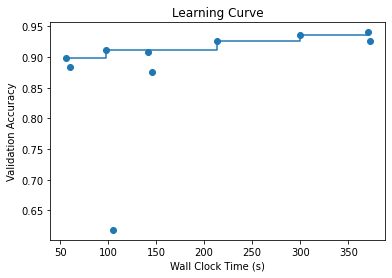

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Spooky-author-identification example

In [1]:
from flaml import AutoML
import ray
import pandas as pd
from sklearn.model_selection import train_test_split
ray.init(num_cpus=4, num_gpus=4, ignore_reinit_error=True)

df = pd.read_csv('/data/xliu127/projects/hyperopt/FLAML/data/spooky-author-identification.csv')
X, y = df.drop('author', axis=1), df['author']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)


print(len(X_train), len(X_val))
automl_model = AutoML()

automl_settings = {
    "time_budget": 1800,                 
    "task": "seq-classification",       
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   
            "model_path": "bert-base-uncased",  
        }
    },
    "metric": "accuracy",
    "gpu_per_trial": 1,  
    "log_file_name": "spooky_bert.log", 
    "log_type": "all",                 
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4,
    "keep_search_state": True,          # keeping the search state
}

automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, **automl_settings)

(train pid=78542) {'train_runtime': 675.882, 'train_samples_per_second': 108.628, 'train_steps_per_second': 6.791, 'train_loss': 0.15587145374491324, 'epoch': 5.0}


(train pid=78542) The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=78542) ***** Running Prediction *****
(train pid=78542)   Num examples = 4895
(train pid=78542)   Batch size = 1


(train pid=78793) {'eval_loss': 0.47973549365997314, 'eval_automl_metric': 0.12134831460674156, 'eval_runtime': 42.4421, 'eval_samples_per_second': 115.334, 'eval_steps_per_second': 115.334, 'epoch': 4.0}
(train pid=78793) {'train_runtime': 482.2078, 'train_samples_per_second': 121.806, 'train_steps_per_second': 1.908, 'train_loss': 0.23729169679724652, 'epoch': 4.0}


(train pid=78793) The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=78793) ***** Running Prediction *****
(train pid=78793)   Num examples = 4895
(train pid=78793)   Batch size = 1


(train pid=78225) {'loss': 0.1844, 'learning_rate': 2.7020242630660653e-06, 'epoch': 3.0}


(train pid=78542) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_e041e7d6_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=5,per_device_trai_2022-07-22_07-09-19/checkpoint-4590/added_tokens.json. We won't load it.
(train pid=78542) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_e041e7d6_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=5,per_device_trai_2022-07-22_07-09-19/checkpoint-4590/vocab.txt
(train pid=78542) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_e041e7d6_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=5,per_device_trai_2022-07-22_07-09-19/checkpoint-4590/tokenizer.json
(train pid=78542) loading file None
(train pid=78542) loading file /data/xliu127/proj

(train pid=78225) {'eval_loss': 0.7813186049461365, 'eval_automl_metric': 0.13564862104187947, 'eval_runtime': 38.0461, 'eval_samples_per_second': 128.66, 'eval_steps_per_second': 128.66, 'epoch': 3.0}
(train pid=78225) {'loss': 0.0829, 'learning_rate': 2.3353000145500413e-06, 'epoch': 3.13}
(train pid=79025) {'eval_loss': 0.5877022743225098, 'eval_automl_metric': 0.11848825331971402, 'eval_runtime': 40.6459, 'eval_samples_per_second': 120.43, 'eval_steps_per_second': 120.43, 'epoch': 4.0}
(train pid=78225) {'loss': 0.0714, 'learning_rate': 1.9685757660340173e-06, 'epoch': 3.27}
(train pid=79025) {'loss': 0.0237, 'learning_rate': 3.91430499829805e-06, 'epoch': 4.36}
(train pid=78225) {'loss': 0.0584, 'learning_rate': 1.6018515175179931e-06, 'epoch': 3.41}
(train pid=78225) {'loss': 0.0836, 'learning_rate': 1.235127269001969e-06, 'epoch': 3.54}
(train pid=78225) {'loss': 0.0335, 'learning_rate': 8.684030204859451e-07, 'epoch': 3.68}
(train pid=79025) {'eval_loss': 0.6322397589683533, 'e

(train pid=79025) The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=79025) ***** Running Prediction *****
(train pid=79025)   Num examples = 4895
(train pid=79025)   Batch size = 1


(train pid=78225) {'loss': 0.0562, 'learning_rate': 5.01678771969921e-07, 'epoch': 3.81}


(train pid=79025) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_9a34cd4a_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_2022-07-22_07-14-32/checkpoint-2295/added_tokens.json. We won't load it.
(train pid=79025) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_9a34cd4a_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_2022-07-22_07-14-32/checkpoint-2295/vocab.txt
(train pid=79025) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_9a34cd4a_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_2022-07-22_07-14-32/checkpoint-2295/tokenizer.json
(train pid=79025) loading file None
(train pid=79025) loading file /data/xliu127/proj

(train pid=78225) {'loss': 0.0527, 'learning_rate': 1.3495452345389687e-07, 'epoch': 3.95}
(train pid=78225) {'eval_loss': 0.8104404211044312, 'eval_automl_metric': 0.12625127681307458, 'eval_runtime': 37.4885, 'eval_samples_per_second': 130.573, 'eval_steps_per_second': 130.573, 'epoch': 4.0}
(train pid=78225) {'train_runtime': 1051.1951, 'train_samples_per_second': 55.875, 'train_steps_per_second': 13.969, 'train_loss': 0.2927411694969607, 'epoch': 4.0}


(train pid=78225) The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=78225) ***** Running Prediction *****
(train pid=78225)   Num examples = 4895
(train pid=78225)   Batch size = 1
(train pid=78225) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_d0e0b7d6_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_train_2022-07-22_07-08-52/checkpoint-14684/added_tokens.json. We won't load it.
(train pid=78225) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_d0e0b7d6_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_train_2022-07-

{'loss': 0.2317, 'learning_rate': 5.95732076822092e-06, 'epoch': 4.35}


[flaml.automl: 07-22 07:35:19] {3457} INFO - retrain transformer for 474.4s
[flaml.automl: 07-22 07:35:19] {3464} INFO - retrained model: None
[flaml.automl: 07-22 07:35:19] {2742} INFO - fit succeeded
[flaml.automl: 07-22 07:35:19] {2743} INFO - Time taken to find the best model: 1118.247492313385


{'train_runtime': 463.5873, 'train_samples_per_second': 158.374, 'train_steps_per_second': 1.24, 'train_loss': 0.20362980179164722, 'epoch': 5.0}


In [2]:
print("the best loss for spooky author identification: {}".format(automl_model.best_loss))

the best loss for spooky author identification: 0.11133810010214507


In [ ]:
automl_settings["fit_kwargs_by_estimator"]["transformer"]["model_path"] = "roberta-base"
automl_settings["log_file_name"] = "spooky_roberta.log"
automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, **automl_settings)

(train pid=50245) {'eval_loss': 0.7418951392173767, 'eval_automl_metric': 0.1284984678243105, 'eval_runtime': 37.3935, 'eval_samples_per_second': 130.905, 'eval_steps_per_second': 130.905, 'epoch': 4.0}
(train pid=50245) {'train_runtime': 565.7729, 'train_samples_per_second': 103.816, 'train_steps_per_second': 6.49, 'train_loss': 0.2802804773409642, 'epoch': 4.0}


(train pid=50245) The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=50245) ***** Running Prediction *****
(train pid=50245)   Num examples = 4895
(train pid=50245)   Batch size = 1


(train pid=50412) {'eval_loss': 1.0893423557281494, 'eval_automl_metric': 0.6024514811031665, 'eval_runtime': 39.7178, 'eval_samples_per_second': 123.245, 'eval_steps_per_second': 123.245, 'epoch': 3.0}
(train pid=50658) {'loss': 0.2369, 'learning_rate': 1.4090340380281214e-05, 'epoch': 2.72}
(train pid=50412) {'train_runtime': 566.9953, 'train_samples_per_second': 77.694, 'train_steps_per_second': 9.714, 'train_loss': 1.0928592581461545, 'epoch': 3.0}
(train pid=49988) {'eval_loss': 1.092341661453247, 'eval_automl_metric': 0.6024514811031665, 'eval_runtime': 38.0057, 'eval_samples_per_second': 128.797, 'eval_steps_per_second': 128.797, 'epoch': 3.0}


(train pid=50412) The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=50412) ***** Running Prediction *****
(train pid=50412)   Num examples = 4895
(train pid=50412)   Batch size = 1
(train pid=50245) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_60247332_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_21-11-36/checkpoint-3672/added_tokens.json. We won't load it.
(train pid=50245) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_60247332_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_202

(train pid=49988) {'loss': 1.0896, 'learning_rate': 1.5104688589428795e-05, 'epoch': 3.13}


(train pid=50412) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_6861ba34_11_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=3,per_device_trai_2022-07-21_21-11-51/checkpoint-3672/added_tokens.json. We won't load it.
(train pid=50412) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_6861ba34_11_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=3,per_device_trai_2022-07-21_21-11-51/checkpoint-3672/vocab.json
(train pid=50412) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_6861ba34_11_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=3,per_device_trai_2022-07-21_21-11-51/checkpoint-3672/merges.txt
(train pid=50412) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/outpu

(train pid=50658) {'loss': 0.2195, 'learning_rate': 1.2404892966371977e-05, 'epoch': 3.0}
(train pid=49988) {'loss': 1.0907, 'learning_rate': 1.2732721160184323e-05, 'epoch': 3.27}
(train pid=50658) {'loss': 0.1252, 'learning_rate': 1.0719445552462741e-05, 'epoch': 3.27}
(train pid=49988) {'loss': 1.0926, 'learning_rate': 1.0360753730939852e-05, 'epoch': 3.41}
(train pid=50658) {'loss': 0.1093, 'learning_rate': 9.033998138553504e-06, 'epoch': 3.54}
(train pid=49988) {'loss': 1.0908, 'learning_rate': 7.988786301695379e-06, 'epoch': 3.54}
(train pid=50658) {'loss': 0.1166, 'learning_rate': 7.348550724644269e-06, 'epoch': 3.81}
(train pid=49988) {'loss': 1.0899, 'learning_rate': 5.616818872450909e-06, 'epoch': 3.68}
(train pid=49988) {'loss': 1.0923, 'learning_rate': 3.244851443206437e-06, 'epoch': 3.81}
(train pid=50658) {'eval_loss': 0.7831101417541504, 'eval_automl_metric': 0.13462717058222673, 'eval_runtime': 37.9679, 'eval_samples_per_second': 128.925, 'eval_steps_per_second': 128.92

(train pid=49988) The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=49988) ***** Running Prediction *****
(train pid=49988)   Num examples = 4895
(train pid=49988)   Batch size = 1


(train pid=50658) {'loss': 0.0542, 'learning_rate': 3.977655896825797e-06, 'epoch': 4.36}


(train pid=49988) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_ebe7d3ee_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=4,per_device_train_2022-07-21_21-08-22/checkpoint-11013/added_tokens.json. We won't load it.
(train pid=49988) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_ebe7d3ee_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=4,per_device_train_2022-07-21_21-08-22/checkpoint-11013/vocab.json
(train pid=49988) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_ebe7d3ee_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=4,per_device_train_2022-07-21_21-08-22/checkpoint-11013/merges.txt
(train pid=49988) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/ou

(train pid=50658) {'loss': 0.0618, 'learning_rate': 2.2922084829165607e-06, 'epoch': 4.63}
(train pid=50658) {'loss': 0.0494, 'learning_rate': 6.06761069007325e-07, 'epoch': 4.9}
(train pid=50658) {'eval_loss': 0.88468998670578, 'eval_automl_metric': 0.12972420837589382, 'eval_runtime': 37.9519, 'eval_samples_per_second': 128.979, 'eval_steps_per_second': 128.979, 'epoch': 5.0}
(train pid=50658) {'train_runtime': 873.0679, 'train_samples_per_second': 84.094, 'train_steps_per_second': 10.515, 'train_loss': 0.27977710040306475, 'epoch': 5.0}


(train pid=50658) The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=50658) ***** Running Prediction *****
(train pid=50658)   Num examples = 4895
(train pid=50658)   Batch size = 1
(train pid=50658) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_bd71ed64_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_2022-07-21_21-14-13/checkpoint-9180/added_tokens.json. We won't load it.
(train pid=50658) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_bd71ed64_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_202

{'loss': 0.5742, 'learning_rate': 3.264882684494973e-05, 'epoch': 1.09}


8
8


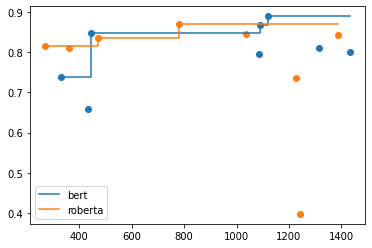

In [4]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

for each_file_name in ['bert', 'roberta']:
    time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
        get_output_from_log(filename='spooky_' + each_file_name + '.log', time_budget=3000)
    print(len(valid_loss_history))
    plt.scatter(time_history, 1 - np.array(valid_loss_history))
    plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')

plt.legend(['bert', 'roberta'])
plt.show()

## 4. Other Tasks

Besides sequence classification, FLAML currently also supports four other tasks (more tasks are to be supported, which can be found on FLAML's documentation website https://microsoft.github.io/FLAML/docs/Examples/AutoML-NLP):

- sequence regression: predicting a float number from the input sequence, e.g., predicting the rating of a hotel review based on the text content;
- token classification: predicting the label of each token in a sequence, e.g., named entity recognition;
- multiple choice: predicting the best second half of a sentence that comes next to the first part of a sentence based on common sensen reasoning. An example is seen below;
- (abstractive) summarization: generating the textual summarization of an input paragraph;

For each task, you only have to change the "Load data and preprocess" with the corresponding data loading process. For example:

### 4.1 Multiple Choice Example

Multiple choice is a task of predicting the best second half of a sentence that follows the first half based on common sense reasoning. An example of multiple-choice classification problem is:

On stage, a woman takes a seat at the piano. She
a) sits on a bench as her sister plays with the doll.
b) smiles with someone as the music plays.
c) is in the crowd, watching the dancers.
d) *nervously sets her fingers on the keys*.

In [12]:
from datasets import load_dataset

train_dataset = load_dataset("swag", split="train").to_pandas().iloc[:10000]
dev_dataset = load_dataset("swag", split="validation").to_pandas().iloc[:10000]
test_dataset = load_dataset("swag", split="test").to_pandas()

custom_sent_keys = [
        "sent1",
        "sent2",
        "ending0",
        "ending1",
        "ending2",
        "ending3",
        "gold-source",
        "video-id",
        "startphrase",
        "fold-ind",
    ]                                                  # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


In [7]:
train_dataset.iloc[0]["sent1"]

'Members of the procession walk down the street holding small horn brass instruments.'

In [13]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

if not ray.is_initialized():
    ray.init()

automl_settings = {
    "time_budget": 500,                 # setting the time budget
    "task": "multichoice-classification",       # setting the task as multiplechoice-classification
    "fit_kwargs_by_estimator": {          # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "ckpt_per_epoch": 1,           # setting the number of checkoints per epoch
            "per_device_eval_batch_size": 16, # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86157) {'eval_loss': 0.6315866112709045, 'eval_automl_metric': 0.18779999999999997, 'eval_runtime': 15.4883, 'eval_samples_per_second': 645.648, 'eval_steps_per_second': 40.353, 'epoch': 1.66}
(train pid=86157) {'train_runtime': 190.7625, 'train_samples_per_second': 87.254, 'train_steps_per_second': 10.909, 'train_loss': 0.5091343906738046, 'epoch': 1.66}
(train pid=86249) {'eval_loss': 1.2118068933486938, 'eval_automl_metric': 0.2015, 'eval_runtime': 15.2585, 'eval_samples_per_second': 655.374, 'eval_steps_per_second': 40.961, 'epoch': 2.87}


(train pid=86157) Using amp half precision backend
(train pid=86157) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: ending3, ending1, video-id, sent1, ending0, sent2, fold-ind, ending2, startphrase, gold-source. If ending3, ending1, video-id, sent1, ending0, sent2, fold-ind, ending2, startphrase, gold-source are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86157) ***** Running Prediction *****
(train pid=86157)   Num examples = 10000
(train pid=86157)   Batch size = 16


(train pid=86249) {'eval_loss': 1.2118068933486938, 'eval_automl_metric': 0.2015, 'eval_runtime': 15.1369, 'eval_samples_per_second': 660.639, 'eval_steps_per_second': 41.29, 'epoch': 2.87}
(train pid=86249) {'train_runtime': 546.3809, 'train_samples_per_second': 156.658, 'train_steps_per_second': 39.165, 'train_loss': 0.5030154804349909, 'epoch': 2.87}
(train pid=86195) {'loss': 0.4854, 'learning_rate': 1.3592147782116173e-06, 'epoch': 2.0}


(train pid=86249) Using amp half precision backend
(train pid=86249) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: fold-ind, sent2, gold-source, ending1, startphrase, sent1, ending0, video-id, ending2, ending3. If fold-ind, sent2, gold-source, ending1, startphrase, sent1, ending0, video-id, ending2, ending3 are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86249) ***** Running Prediction *****
(train pid=86249)   Num examples = 10000
(train pid=86249)   Batch size = 16


(train pid=86195) {'eval_loss': 0.49709731340408325, 'eval_automl_metric': 0.17600000000000005, 'eval_runtime': 15.4983, 'eval_samples_per_second': 645.232, 'eval_steps_per_second': 40.327, 'epoch': 2.0}


2022-03-19 14:41:56,719	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86195) {'eval_loss': 0.5254333019256592, 'eval_automl_metric': 0.17800000000000005, 'eval_runtime': 15.45, 'eval_samples_per_second': 647.251, 'eval_steps_per_second': 40.453, 'epoch': 3.0}
(train pid=86195) {'loss': 0.3989, 'learning_rate': 3.8051750127352887e-07, 'epoch': 3.0}


2022-03-19 14:42:56,729	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86195) {'eval_loss': 0.5254867076873779, 'eval_automl_metric': 0.17789999999999995, 'eval_runtime': 15.424, 'eval_samples_per_second': 648.341, 'eval_steps_per_second': 40.521, 'epoch': 3.0}
(train pid=86195) {'eval_loss': 0.5332269072532654, 'eval_automl_metric': 0.17830000000000001, 'eval_runtime': 15.4452, 'eval_samples_per_second': 647.45, 'eval_steps_per_second': 40.466, 'epoch': 3.39}
(train pid=86195) {'train_runtime': 382.2827, 'train_samples_per_second': 88.597, 'train_steps_per_second': 11.076, 'train_loss': 0.5299136270370808, 'epoch': 3.39}


2022-03-19 14:43:56,739	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86195) Using amp half precision backend
(train pid=86195) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: ending2, sent1, ending0, sent2, ending3, video-id, gold-source, ending1, startphrase, fold-ind. If ending2, sent1, ending0, sent2, ending3, video-id, gold-source, ending1, startphrase, fold-ind are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86195) ***** Running Prediction *****
(train pid=86195)   Num examples = 10000
(train pid=86195)   Batch size = 16
2022-03-19 14:44:14,271	INFO tune.py:639 -- Total run time: 795.18 seconds (504.18 seconds for the tuning loop).
[flaml.automl: 03-19 14:44:19] {2837} INFO - selected model: None
/data/installation/anaconda3/envs/tmp/lib

{'loss': 0.6603, 'learning_rate': 4.631567529441369e-06, 'epoch': 1.0}


[flaml.automl: 03-19 14:46:08] {2947} INFO - retrain transformer for 109.2s
[flaml.automl: 03-19 14:46:08] {2954} INFO - retrained model: None
[flaml.automl: 03-19 14:46:08] {2283} INFO - fit succeeded
[flaml.automl: 03-19 14:46:08] {2284} INFO - Time taken to find the best model: 319.927033662796


{'train_runtime': 96.899, 'train_samples_per_second': 245.031, 'train_steps_per_second': 30.63, 'train_loss': 0.6602518278346073, 'epoch': 1.0}


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 0.00021956991427751982, 'num_train_epochs': 0.3549576494055084, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07425273520338253, 'weight_decay': 0.03879221030529465, 'adam_epsilon': 3.7880482987985576e-08, 'seed': 43, 'global_max_steps': 444, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 0.00021956991427751982, 'num_train_epochs': 0.3549576494055084, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07425273520338253, 'weight_decay': 0.03879221030529465, 'adam_epsilon': 3.7880482987985576e-08, 'seed': 43, 'global_max_steps': 444, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, '

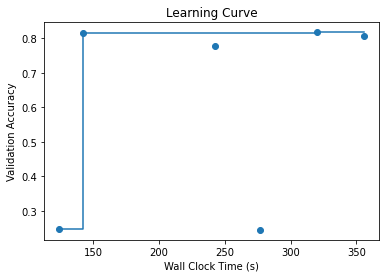

In [14]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### 4.2 Text Summarization Example

The text summarization task summarizes a long text into a short sentence. For example:

- Document: Army explosives experts were called out to deal with a suspect package at the offices on the Newtownards Road on Friday night. Roads were sealed off and traffic diverted as a controlled explosion was carried out. The premises, used by East Belfast MP Naomi Long, have been targeted a number of times. Most recently, petrol bomb attacks were carried out on the offices on consecutive nights in April and May. The attacks began following a Belfast City Council vote in December 2012 restricting the flying of the union flag at the City Hall. Condemning the latest hoax, Alliance MLA Chris Lyttle said: "It is a serious incident for the local area, it causes serious disruption, it puts people's lives at risk, it can prevent emergency services reaching the area. "Ultimately we need people with information to share that with the police in order for them to do their job and bring these people to justice.

- Summary: A suspicious package left outside an Alliance Party office in east Belfast has been declared a hoax.

In this example, we use FLAML to perform *abstractive summarization* using the t5-small language model, i.e., the summary is generated word-by-word. 

In [15]:
from datasets import load_dataset

train_dataset = load_dataset("xsum", split="train").to_pandas()
print(len(train_dataset))
dev_dataset = load_dataset("xsum", split="validation").to_pandas()
test_dataset = load_dataset("xsum", split="test").to_pandas()

custom_sent_keys = ["document"]       # specify the column names of the input sentences
label_key = "summary"                 # specify the column name of the label                              

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


204045


Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)
Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


In [16]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
if not ray.is_initialized():
    ray.init()

automl_settings = {
    "time_budget": 500,         # setting the time budget
    "task": "summarization",    # setting the task as summarization
    "fit_kwargs_by_estimator": {  # if model_path is not set, the default model is t5-small: https://huggingface.co/t5-small
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "ckpt_per_epoch": 1,    # setting the number of checkoints per epoch
            "model_path": "t5-small",
            "per_device_eval_batch_size": 16,  # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,  # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",  # set the file to save the log for HPO
    "log_type": "all",   # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},  # set whether to use Ray
    "metric": "rouge1",
    "n_concurrent_trials": 4,  # sample: False # if the time is sufficient (e.g., longer than one trial's running time), you can set 
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86232) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86232)   warnings.warn(


(train pid=86232) {'loss': 8.7635, 'learning_rate': 1.2308416834153697e-05, 'epoch': 0.11}


(train pid=86184) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86184)   warnings.warn(
(train pid=86225) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86225)   warnings.warn(
(train pid=86160) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.opti

(train pid=86232) {'eval_loss': 6.893245697021484, 'eval_automl_metric': 0.8537338408275918, 'eval_runtime': 102.2734, 'eval_samples_per_second': 110.801, 'eval_steps_per_second': 6.932, 'epoch': 0.11}


2022-03-19 14:57:00,687	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86184) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86184) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'eval_loss': 7.381210803985596, 'eval_automl_metric': 0.8475751825208984, 'eval_runtime': 107.4032, 'eval_samples_per_second': 105.509, 'eval_steps_per_second': 6.601, 'epoch': 0.16}


(train pid=86160) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86160) [nltk_data]   Package punkt is already up-to-date!
(train pid=86225) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86225) [nltk_data]   Package punkt is already up-to-date!


(train pid=86160) {'eval_loss': 10.150897979736328, 'eval_automl_metric': 0.8566791839938478, 'eval_runtime': 108.2143, 'eval_samples_per_second': 104.718, 'eval_steps_per_second': 6.552, 'epoch': 0.36}


2022-03-19 14:58:00,697	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86225) {'eval_loss': 11.665904998779297, 'eval_automl_metric': 0.858011676038827, 'eval_runtime': 109.4667, 'eval_samples_per_second': 103.52, 'eval_steps_per_second': 6.477, 'epoch': 0.38}


(train pid=86232) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86232) [nltk_data]   Package punkt is already up-to-date!


(train pid=86232) {'eval_loss': 6.893245697021484, 'eval_automl_metric': 0.8537338408275918, 'eval_runtime': 110.7246, 'eval_samples_per_second': 102.344, 'eval_steps_per_second': 6.403, 'epoch': 0.11}
(train pid=86232) {'train_runtime': 220.8946, 'train_samples_per_second': 4.648, 'train_steps_per_second': 0.149, 'train_loss': 8.763471198804451, 'epoch': 0.11}


2022-03-19 14:59:00,706	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86232) Using amp half precision backend
(train pid=86232) ***** Running Prediction *****
(train pid=86232)   Num examples = 11332
(train pid=86232)   Batch size = 16
(train pid=86184) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86184) [nltk_data]   Package punkt is already up-to-date!
(train pid=86160) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86160) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'eval_loss': 7.381210803985596, 'eval_automl_metric': 0.8475751825208984, 'eval_runtime': 109.1975, 'eval_samples_per_second': 103.775, 'eval_steps_per_second': 6.493, 'epoch': 0.16}


(train pid=86225) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86225) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'train_runtime': 232.9303, 'train_samples_per_second': 10.067, 'train_steps_per_second': 1.262, 'train_loss': 9.880440506280637, 'epoch': 0.16}
(train pid=86160) {'eval_loss': 10.150897979736328, 'eval_automl_metric': 0.8566791839938478, 'eval_runtime': 108.3182, 'eval_samples_per_second': 104.618, 'eval_steps_per_second': 6.546, 'epoch': 0.36}
(train pid=86160) {'train_runtime': 232.4568, 'train_samples_per_second': 92.218, 'train_steps_per_second': 2.887, 'train_loss': 11.215172903878349, 'epoch': 0.36}
(train pid=86225) {'eval_loss': 11.665904998779297, 'eval_automl_metric': 0.858011676038827, 'eval_runtime': 110.526, 'eval_samples_per_second': 102.528, 'eval_steps_per_second': 6.415, 'epoch': 0.38}
(train pid=86225) {'train_runtime': 236.6253, 'train_samples_per_second': 19.714, 'train_steps_per_second': 0.621, 'train_loss': 11.549961930614407, 'epoch': 0.38}


2022-03-19 15:00:00,942	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86184) Using amp half precision backend
(train pid=86184) ***** Running Prediction *****
(train pid=86184)   Num examples = 11332
(train pid=86184)   Batch size = 16
(train pid=86160) Using amp half precision backend
(train pid=86160) ***** Running Prediction *****
(train pid=86160)   Num examples = 11332
(train pid=86160)   Batch size = 16
(train pid=86225) Using amp half precision backend
(train pid=86225) ***** Running Prediction *****
(train pid=86225)   Num examples = 11332
(train pid=86225)   Batch size = 16
2022-03-19 15:01:00,948	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
2022-03-19 15:02:20,150	INFO tune.py:639 -- Total run time: 950.87 seconds (500.36 seconds for the tuning loop).
[flaml.automl: 03-19 15:02:25] {

{'train_runtime': 14.6848, 'train_samples_per_second': 13894.959, 'train_steps_per_second': 434.258, 'train_loss': 10.199760437011719, 'epoch': 0.02}


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 3.6439277745413994e-06, 'num_train_epochs': 0.454119690781029, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04654549348562217, 'weight_decay': 0.06669806327326033, 'adam_epsilon': 2.5833461668835812e-08, 'seed': 42, 'global_max_steps': 125, 'learner': 'transformer', 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 3.6439277745413994e-06, 'num_train_epochs': 0.454119690781029, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04654549348562217, 'weight_decay': 0.06669806327326033, 'adam_epsilon': 2.5833461668835812e-08, 'seed': 42, 'global_max_steps': 125, 'learner': 'transformer', 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, '

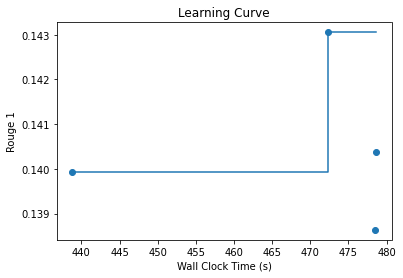

In [17]:

from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Rouge 1')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

In [18]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(["Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.\nWorkers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.\nThe Welsh Government said more people than ever were getting help to address housing problems.\nChanges to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.\nPrison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.\nHowever, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.\nAndrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the need for accommodation was 'chronic'.\n'There\'s a desperate need for it, finding suitable accommodation for those leaving prison there is just a lack of it everywhere,' he said.\n'It could take six months to a year, without a lot of help they could be on the streets for six months.\n'When you think of the consequences of either being on the street, especially with the cold weather at the moment or you may have a roof over your head, sometimes there is only one choice.'\nMr Stevens believes building more one-bedroom flats could help ease the problem.\n'The average price is a hundred pounds a week to keep someone in a rented flat, prison is a lot more than that so I would imagine it would save the public purse quite a few pounds,' he said.\nOfficial figures show 830 one-bedroom properties were built in the year to March 2016, of an overall total of 6,900 new properties in Wales.\nMarc, 50, who has been in and out of prison for the past 20 years for burglary offences, said he struggled to find accommodation each time he was released.\nHe said he would ask himself: 'Where am I going to stay? Where am I going to live? Have I got somewhere where I can see my daughter.'\n'You\'re put out among the same sort of people doing the same sort of thing, and it\'s difficult, it\'s difficult to get away from it. It\'s like every man for himself, there\'s nothing.'\nMarc has now found stable accommodation with homeless charity Emmaus and said it had been life changing.\n'You feel safe, you got hot food, you\'ve got company of people in similar situations to yourself but all dealing with different issues. It\'s a constructive, helpful atmosphere,' he said.\nTom Clarke, chief executive of Emmaus South Wales, agreed there was not enough support available.\n'We do still see [people] homeless on the streets, so clearly they haven\'t got accommodation and haven\'t got provision,' he said.\n'I think the key is connecting people with the services they need. I don\'t delude myself that Emmaus can offer a one size fits all for everyone, we can\'t.\n'But there must be other opportunities and given suitable encouragement I believe that can and should happen.'\nA Welsh Government spokesman said the national pathway for homeless services to children, young people and adults in the secure estate had prevented many people from losing their home whilst serving their prison sentence.\nIt added there were already significant demands for one-bedroom flats across the public and private sector and it was providing 20,000 new affordable homes in the next five years."])
print('Predicted labels', y_pred)

Using amp half precision backend
***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Predicted labels ['prison link Cymru said some ex-offenders were living rough for up to ']
